In [1]:
# ── CELL 1 │ Installs ──────────────────────────────────────────────────────
!pip install kaggle opencv-python-headless scikit-image lightgbm torch torchvision -q

In [3]:
# ── CELL 3 │ Download datasets ──────────────────────────────────────────────
!kaggle datasets download -d divg07/casia-20-image-tampering-detection-dataset -p /tmp/casia --unzip -q
!kaggle datasets download -d cashbowman/ai-generated-images-vs-real-images       -p /tmp/aigen --unzip -q

Dataset URL: https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset
License(s): unknown
Dataset URL: https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images
License(s): Community Data License Agreement - Sharing - Version 1.0


In [4]:
# ── CELL 4 │ Restructure → Real / AI / Tampered (≤500 each, PNG) ──────────
import pathlib, random, shutil, itertools
from PIL import Image

random.seed(42)
DEST = pathlib.Path("dataset")
for folder in ["Real", "AI", "Tampered"]:
    (DEST / folder).mkdir(parents=True, exist_ok=True)

def gather(roots, exts={".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}):
    return [p for r in roots for p in pathlib.Path(r).rglob("*") if p.suffix.lower() in exts]

def copy_as_png(src_list, dest_folder, limit=500):
    random.shuffle(src_list)
    saved = 0
    for src in src_list:
        if saved >= limit:
            break
        try:
            img = Image.open(src).convert("RGB")
            out = dest_folder / f"{saved:04d}.png"
            img.save(out, "PNG")
            saved += 1
        except Exception:
            pass
    print(f"  {dest_folder.name}: {saved} images saved")

# CASIA 2.0 typical layout: Au/ = authentic, Tp/ = tampered
casia_root = pathlib.Path("/tmp/casia")
au_dirs  = [d for d in casia_root.rglob("Au")  if d.is_dir()]
tp_dirs  = [d for d in casia_root.rglob("Tp")  if d.is_dir()]
# fallback – if layout differs, grab all and split
if not au_dirs and not tp_dirs:
    all_casia = gather([casia_root])
    au_dirs_files = all_casia[:len(all_casia)//2]
    tp_dirs_files = all_casia[len(all_casia)//2:]
else:
    au_dirs_files = gather(au_dirs  or [casia_root])
    tp_dirs_files = gather(tp_dirs  or [casia_root])

# cashbowman dataset: real_images/ and ai_generated/ (or similar)
aigen_root = pathlib.Path("/tmp/aigen")
real_dirs  = [d for d in aigen_root.rglob("*") if d.is_dir() and "real" in d.name.lower()]
ai_dirs    = [d for d in aigen_root.rglob("*") if d.is_dir() and ("ai" in d.name.lower() or "fake" in d.name.lower() or "generated" in d.name.lower())]
if not real_dirs:
    real_dirs = [aigen_root]
if not ai_dirs:
    ai_dirs = [aigen_root]

real_files     = gather(au_dirs_files if isinstance(au_dirs_files[0], pathlib.Path) else []) + gather(real_dirs)
ai_files       = gather(ai_dirs)
tampered_files = gather(tp_dirs_files if isinstance(tp_dirs_files[0], pathlib.Path) else [])

# handle when au_dirs_files is already a flat list
real_files     = (au_dirs_files if au_dirs_files and isinstance(au_dirs_files[0], pathlib.Path) else []) + gather(real_dirs)
tampered_files = (tp_dirs_files if tp_dirs_files and isinstance(tp_dirs_files[0], pathlib.Path) else [])
ai_files       = gather(ai_dirs)

copy_as_png(real_files,     DEST / "Real",     500)
copy_as_png(ai_files,       DEST / "AI",       500)
copy_as_png(tampered_files, DEST / "Tampered", 500)

shutil.rmtree("/tmp/casia", ignore_errors=True)
shutil.rmtree("/tmp/aigen", ignore_errors=True)
print("Cleanup done.")

  Real: 500 images saved
  AI: 500 images saved
  Tampered: 500 images saved
Cleanup done.


In [5]:
# ── CELL 5 │ Carve out test images before any training ─────────────────────
import pathlib, random, shutil

random.seed(0)
TEST_DIR = pathlib.Path("test_images")
TEST_DIR.mkdir(exist_ok=True)
TEST_N = 15   # 15 per class

for cls in ["Real", "AI", "Tampered"]:
    src_folder = pathlib.Path("dataset") / cls
    images = list(src_folder.glob("*.png"))
    chosen = random.sample(images, min(TEST_N, len(images)))
    out_dir = TEST_DIR / cls
    out_dir.mkdir(exist_ok=True)
    for p in chosen:
        shutil.copy(p, out_dir / p.name)
        p.unlink()   # remove from training pool

print("Test images saved to test_images/")
for cls in ["Real","AI","Tampered"]:
    print(f"  {cls}: {len(list((TEST_DIR/cls).glob('*.png')))} test | {len(list((pathlib.Path('dataset')/cls).glob('*.png')))} train")

Test images saved to test_images/
  Real: 15 test | 485 train
  AI: 15 test | 485 train
  Tampered: 15 test | 485 train


In [6]:
# ── CELL 6 │ Feature extraction helpers ─────────────────────────────────────
import numpy as np
import cv2
from PIL import Image
import io
from skimage.filters.rank import entropy as rank_entropy
from skimage.morphology import disk
from skimage.color import rgb2gray
from scipy.stats import skew, kurtosis

def ela(img_pil, quality=75):
    buf = io.BytesIO()
    img_pil.save(buf, "JPEG", quality=quality)
    buf.seek(0)
    recompressed = Image.open(buf).convert("RGB")
    ela_arr = np.abs(np.array(img_pil, dtype=np.float32) - np.array(recompressed, dtype=np.float32))
    return ela_arr

def extract_features(path):
    img_pil = Image.open(path).convert("RGB")
    img_arr = np.array(img_pil, dtype=np.uint8)
    gray    = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)

    feats = {}

    # ── RGB stats ──────────────────────────────────────────────────────────────
    for i, ch in enumerate(["R","G","B"]):
        c = img_arr[:,:,i].astype(np.float32)
        feats[f"{ch}_mean"]  = c.mean()
        feats[f"{ch}_std"]   = c.std()
        feats[f"{ch}_skew"]  = float(skew(c.ravel()))
        feats[f"{ch}_kurt"]  = float(kurtosis(c.ravel()))

    # ── Luminance ──────────────────────────────────────────────────────────────
    lum = 0.2126*img_arr[:,:,0] + 0.7152*img_arr[:,:,1] + 0.0722*img_arr[:,:,2]
    feats["lum_mean"] = lum.mean()
    feats["lum_std"]  = lum.std()

    # ── Global entropy ─────────────────────────────────────────────────────────
    hist, _ = np.histogram(gray.ravel(), bins=256, range=(0,256), density=True)
    hist = hist[hist > 0]
    feats["entropy_global"] = -np.sum(hist * np.log2(hist))

    # ── Local entropy mean ─────────────────────────────────────────────────────
    loc_ent = rank_entropy(gray, disk(5))
    feats["entropy_local_mean"] = loc_ent.mean()
    feats["entropy_local_std"]  = loc_ent.std()

    # ── ELA ────────────────────────────────────────────────────────────────────
    ela_arr = ela(img_pil)
    feats["ela_max"]  = ela_arr.max()
    feats["ela_mean"] = ela_arr.mean()
    feats["ela_std"]  = ela_arr.std()

    # ── Laplacian variance (sharpness / noise) ─────────────────────────────────
    feats["laplacian_var"] = cv2.Laplacian(gray, cv2.CV_64F).var()

    # ── JPEG blocking artefact proxy ──────────────────────────────────────────
    # difference between 8-pixel-apart rows/cols (DCT block boundary sensitivity)
    block_h = np.abs(img_arr[8::8,:,:].astype(np.float32) - img_arr[7:-1:8,:,:].astype(np.float32))
    block_v = np.abs(img_arr[:,8::8,:].astype(np.float32) - img_arr[:,7:-1:8,:].astype(np.float32))
    feats["block_artefact"] = (block_h.mean() + block_v.mean()) / 2

    # ── High-frequency power ratio ─────────────────────────────────────────────
    f  = np.fft.fft2(gray.astype(np.float32))
    fs = np.fft.fftshift(f)
    mag = np.abs(fs)
    h, w = mag.shape
    cy, cx = h//2, w//2
    r = min(h,w)//4
    low_mask = np.zeros_like(mag); low_mask[cy-r:cy+r, cx-r:cx+r] = 1
    feats["hf_ratio"] = mag[low_mask==0].sum() / (mag.sum() + 1e-9)

    return feats

print("Feature extractor ready. Feature count:", len(extract_features(list(pathlib.Path("dataset/Real").glob("*.png"))[0])))

Feature extractor ready. Feature count: 23


In [ ]:
# ── CELL 7 │ Compute features for all images ────────────────────────────────
import pathlib, numpy as np, pandas as pd
from tqdm.notebook import tqdm

CLASSES = {"Real": 0, "AI": 1, "Tampered": 1}   # 0=real, 1=fake

rows = []
raw_pixels = {"Real": [], "AI": [], "Tampered": []}   # store small pixel arrays for plotting

for cls, label in CLASSES.items():
    paths = list((pathlib.Path("dataset") / cls).glob("*.png"))
    for p in tqdm(paths, desc=cls):
        try:
            feats = extract_features(p)
            feats["class"] = cls
            feats["label"] = label
            rows.append(feats)
            if len(raw_pixels[cls]) < 30:    # keep 30 images worth of pixels
                arr = np.array(__import__("PIL").Image.open(p).convert("RGB"))
                raw_pixels[cls].append(arr)
        except Exception as e:
            pass

df = pd.DataFrame(rows)
print(df.shape)
df.head(3)

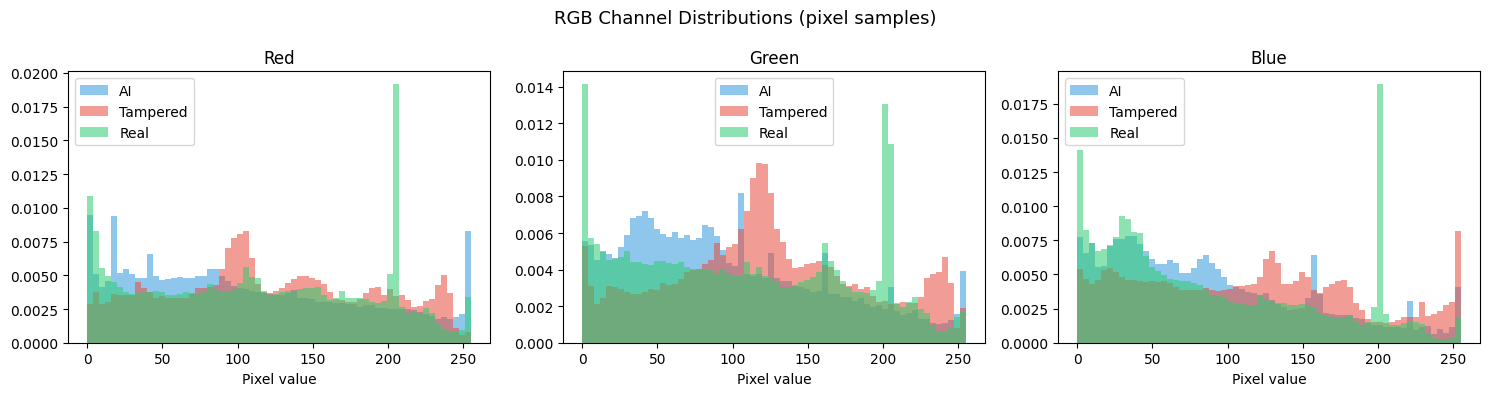

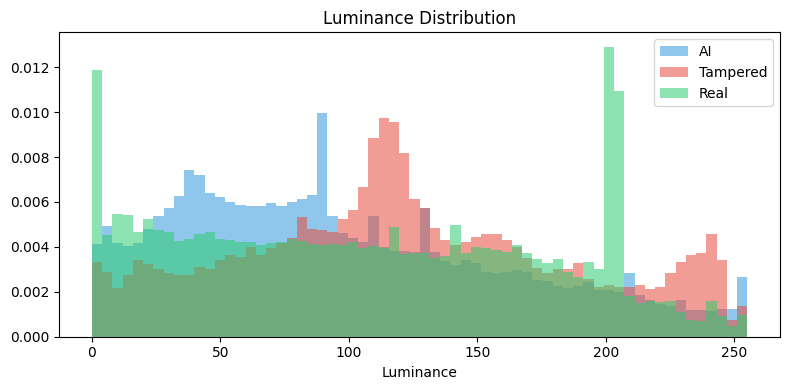

/tmp/ipython-input-3490636068.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=["AI","Tampered","Real"],
/tmp/ipython-input-3490636068.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=["AI","Tampered","Real"],
/tmp/ipython-input-3490636068.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=["AI","Tampered","Real"],
/tmp/ipython-input-3490636068.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9

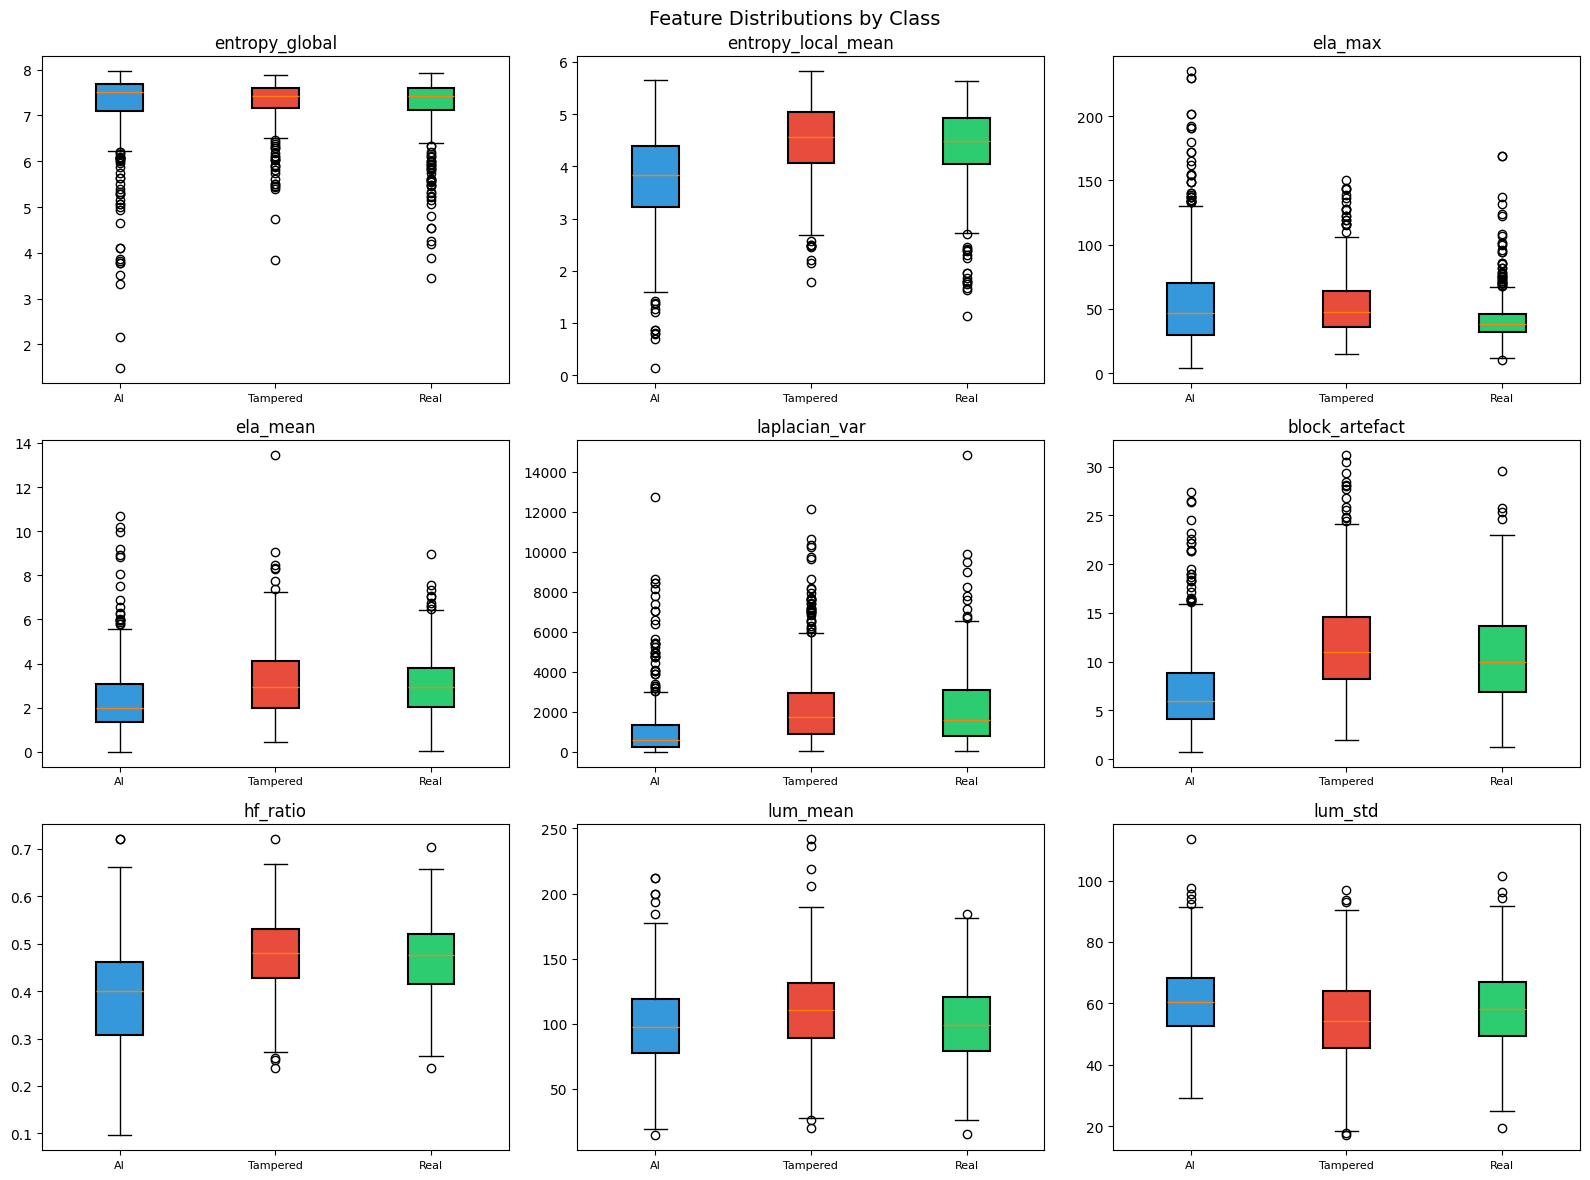

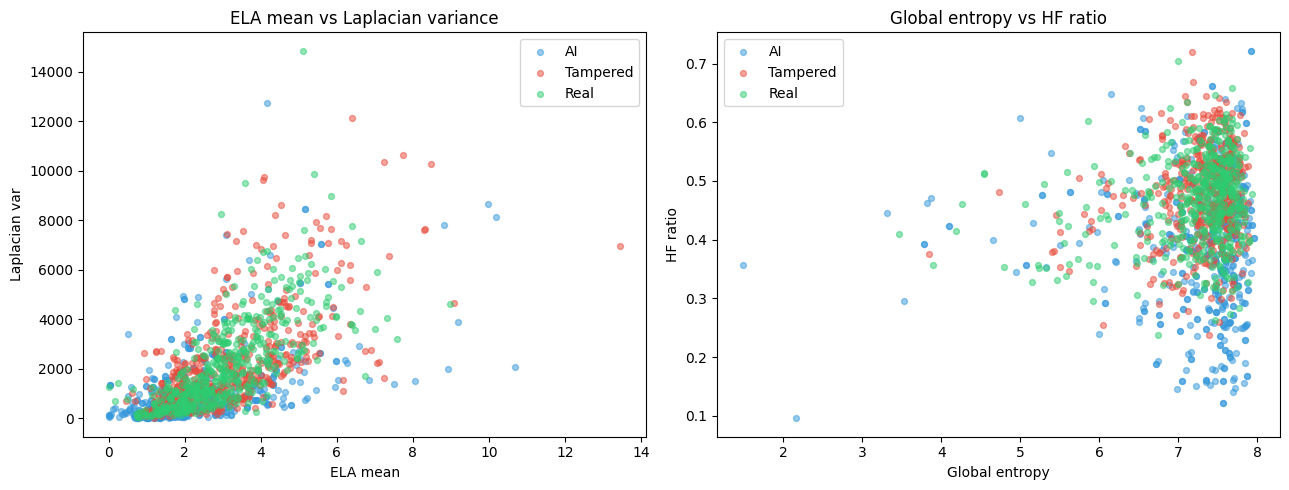

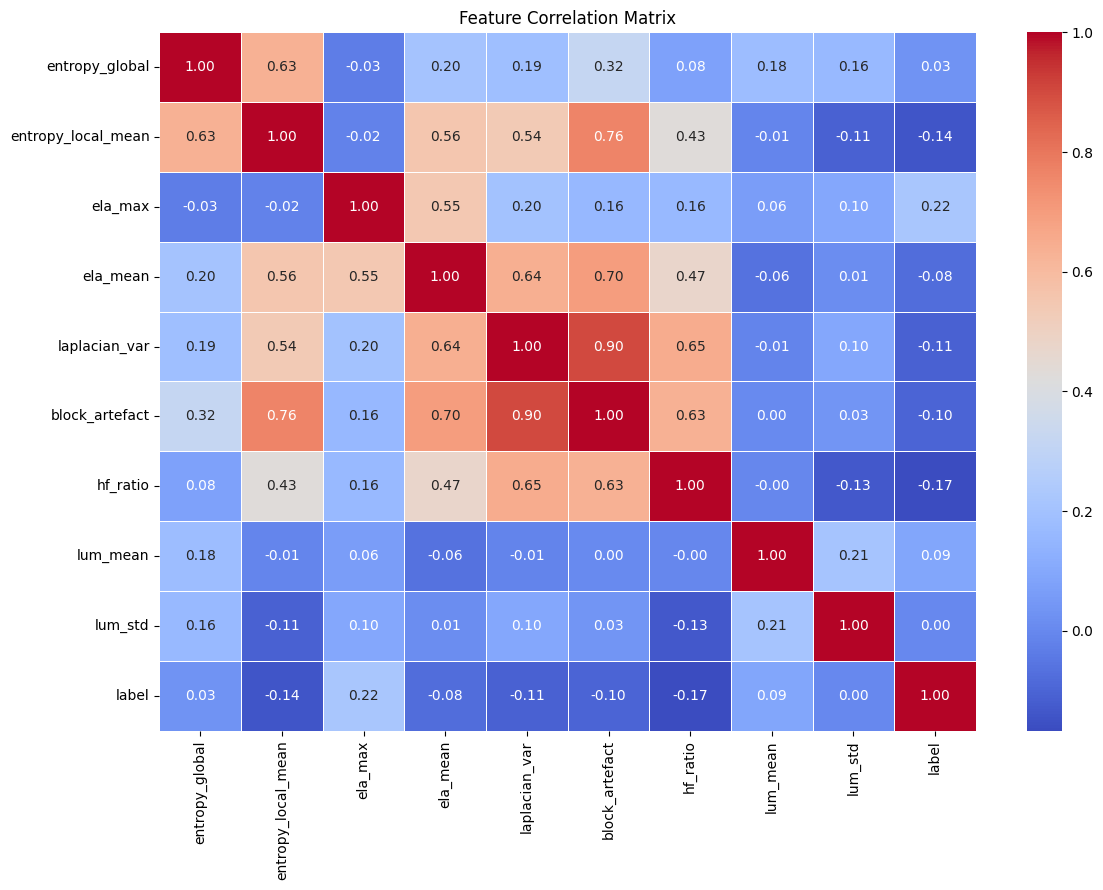

All plots saved to pixel_analysis.pdf


In [9]:
# ── CELL 8 │ Pixel-level analysis plots ─────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np

COLORS = {"Real": "#2ecc71", "AI": "#3498db", "Tampered": "#e74c3c"}
ORDER  = ["AI", "Tampered", "Real"]   # Real drawn last → on top

pdf = matplotlib.backends.backend_pdf.PdfPages("pixel_analysis.pdf")

# ── 1. RGB channel distributions ───────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("RGB Channel Distributions (pixel samples)", fontsize=13)
for ax, ch, idx in zip(axes, ["Red","Green","Blue"], [0,1,2]):
    for cls in ORDER:
        sample = np.concatenate([a[:,:,idx].ravel() for a in raw_pixels[cls]])
        ax.hist(sample, bins=64, range=(0,255), alpha=0.55, color=COLORS[cls], label=cls, density=True,
                zorder=3 if cls=="Real" else 2)
    ax.set_title(ch); ax.set_xlabel("Pixel value"); ax.legend()
plt.tight_layout(); pdf.savefig(fig); plt.show()

# ── 2. Luminance distribution ──────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
for cls in ORDER:
    lums = np.concatenate([
        (0.2126*a[:,:,0] + 0.7152*a[:,:,1] + 0.0722*a[:,:,2]).ravel()
        for a in raw_pixels[cls]
    ])
    ax.hist(lums, bins=64, range=(0,255), alpha=0.55, color=COLORS[cls], label=cls, density=True,
            zorder=3 if cls=="Real" else 2)
ax.set_title("Luminance Distribution"); ax.set_xlabel("Luminance"); ax.legend()
plt.tight_layout(); pdf.savefig(fig); plt.show()

# ── 3. Box plots for engineered features ───────────────────────────────────────
FEAT_COLS = ["entropy_global","entropy_local_mean","ela_max","ela_mean",
             "laplacian_var","block_artefact","hf_ratio","lum_mean","lum_std"]

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle("Feature Distributions by Class", fontsize=14)
for ax, col in zip(axes.ravel(), FEAT_COLS):
    data = [df[df["class"]==cls][col].dropna().values for cls in ["AI","Tampered","Real"]]
    bp = ax.boxplot(data, patch_artist=True, labels=["AI","Tampered","Real"],
                    zorder=3, boxprops=dict(linewidth=1.5))
    for patch, cls in zip(bp["boxes"], ["AI","Tampered","Real"]):
        patch.set_facecolor(COLORS[cls])
        patch.set_zorder(3 if cls=="Real" else 2)
    ax.set_title(col); ax.tick_params(axis="x", labelsize=8)
plt.tight_layout(); pdf.savefig(fig); plt.show()

# ── 4. Pairwise scatter ────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
for cls in ORDER:
    sub = df[df["class"]==cls]
    z = 3 if cls=="Real" else 2
    axes[0].scatter(sub["ela_mean"], sub["laplacian_var"], alpha=0.5, s=18,
                    color=COLORS[cls], label=cls, zorder=z)
    axes[1].scatter(sub["entropy_global"], sub["hf_ratio"], alpha=0.5, s=18,
                    color=COLORS[cls], label=cls, zorder=z)
axes[0].set_xlabel("ELA mean"); axes[0].set_ylabel("Laplacian var"); axes[0].legend()
axes[0].set_title("ELA mean vs Laplacian variance")
axes[1].set_xlabel("Global entropy"); axes[1].set_ylabel("HF ratio"); axes[1].legend()
axes[1].set_title("Global entropy vs HF ratio")
plt.tight_layout(); pdf.savefig(fig); plt.show()

# ── 5. Correlation heatmap ─────────────────────────────────────────────────────
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 9))
corr = df[FEAT_COLS + ["label"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax, linewidths=0.5)
ax.set_title("Feature Correlation Matrix")
plt.tight_layout(); pdf.savefig(fig); plt.show()

pdf.close()
print("All plots saved to pixel_analysis.pdf")

In [10]:
# ── CELL 9 │ Prepare feature matrix ─────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

FEATURE_COLS = [c for c in df.columns if c not in ("class","label")]

X = df[FEATURE_COLS].values.astype(np.float32)
y = df["label"].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)

print(f"Train: {X_train.shape}  Val: {X_val.shape}  Features: {FEATURE_COLS}")

Train: (1164, 23)  Val: (291, 23)  Features: ['R_mean', 'R_std', 'R_skew', 'R_kurt', 'G_mean', 'G_std', 'G_skew', 'G_kurt', 'B_mean', 'B_std', 'B_skew', 'B_kurt', 'lum_mean', 'lum_std', 'entropy_global', 'entropy_local_mean', 'entropy_local_std', 'ela_max', 'ela_mean', 'ela_std', 'laplacian_var', 'block_artefact', 'hf_ratio']


=== Naive Threshold Classifier ===
              precision    recall  f1-score   support

        Real       0.28      0.31      0.29        97
        Fake       0.63      0.60      0.62       194

    accuracy                           0.50       291
   macro avg       0.46      0.45      0.45       291
weighted avg       0.52      0.50      0.51       291

Accuracy:  0.502
Precision: 0.634
Recall:    0.598


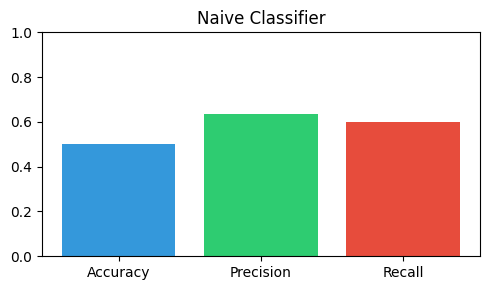

In [11]:
# ── CELL 10 │ Naive threshold classifier ────────────────────────────────────
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import numpy as np

# Real images tend to have lower ELA and lower HF ratio
# Threshold: if ela_mean > median → fake
ela_idx  = FEATURE_COLS.index("ela_mean")
hf_idx   = FEATURE_COLS.index("hf_ratio")
ent_idx  = FEATURE_COLS.index("entropy_global")

ela_thresh = np.median(X_train[:, ela_idx])
hf_thresh  = np.median(X_train[:, hf_idx])

def naive_predict(X):
    votes = (
        (X[:, ela_idx] > ela_thresh).astype(int) +
        (X[:, hf_idx]  > hf_thresh ).astype(int)
    )
    return (votes >= 1).astype(int)

y_pred_naive = naive_predict(X_val)

print("=== Naive Threshold Classifier ===")
print(classification_report(y_val, y_pred_naive, target_names=["Real","Fake"]))
print(f"Accuracy:  {accuracy_score(y_val, y_pred_naive):.3f}")
print(f"Precision: {precision_score(y_val, y_pred_naive):.3f}")
print(f"Recall:    {recall_score(y_val, y_pred_naive):.3f}")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,3))
ax.bar(["Accuracy","Precision","Recall"],
       [accuracy_score(y_val,y_pred_naive), precision_score(y_val,y_pred_naive), recall_score(y_val,y_pred_naive)],
       color=["#3498db","#2ecc71","#e74c3c"])
ax.set_ylim(0,1); ax.set_title("Naive Classifier"); plt.tight_layout(); plt.show()

=== Naive Entropy Threshold Classifier ===
Thresholds used:
  entropy_global    < 7.4508  → fake vote
  entropy_local_mean > 4.3659  → fake vote
  entropy_local_std  > 1.1626  → fake vote

              precision    recall  f1-score   support

        Real       0.29      0.41      0.34        97
        Fake       0.62      0.49      0.55       194

    accuracy                           0.46       291
   macro avg       0.46      0.45      0.44       291
weighted avg       0.51      0.46      0.48       291



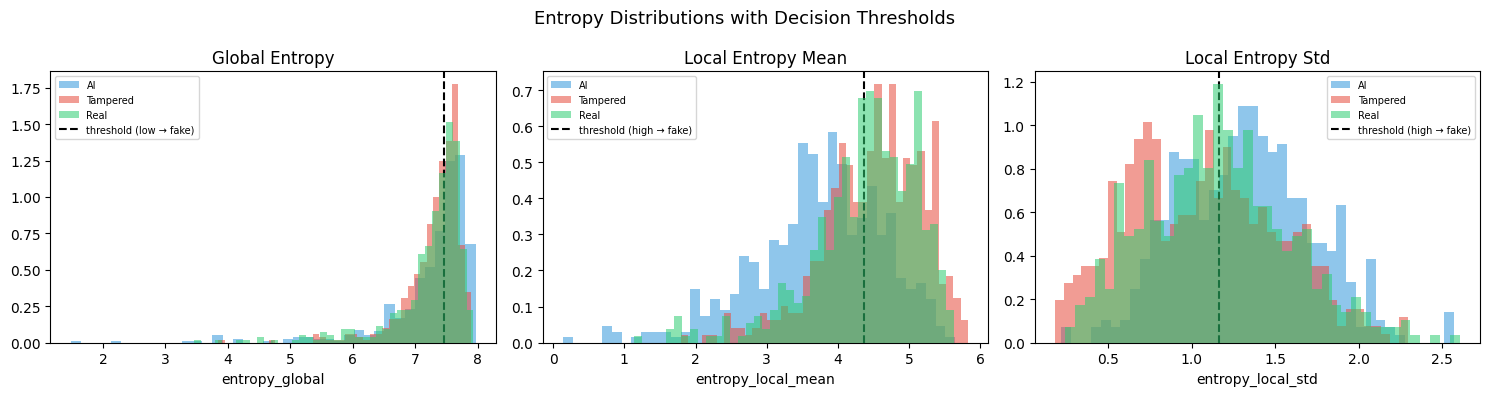

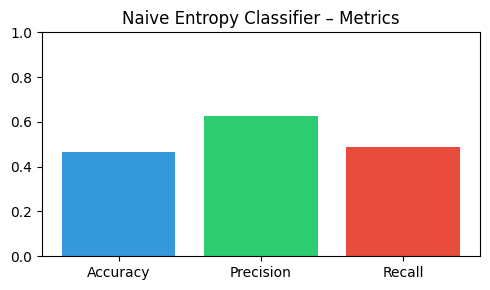

In [12]:
# ── CELL 10B │ Naive Threshold Classifier – Entropy-based ────────────────────
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

ent_g_idx  = FEATURE_COLS.index("entropy_global")
ent_l_idx  = FEATURE_COLS.index("entropy_local_mean")
ent_ls_idx = FEATURE_COLS.index("entropy_local_std")

# Real images tend to have smoother, more uniform entropy profiles
# Fake/tampered images show higher local entropy variance and often lower global entropy
# (AI images) or patchy local entropy spikes (tampered images)

ent_g_thresh  = np.median(X_train[:, ent_g_idx])
ent_l_thresh  = np.median(X_train[:, ent_l_idx])
ent_ls_thresh = np.median(X_train[:, ent_ls_idx])

def entropy_predict(X):
    # Vote across three entropy signals:
    # high local entropy std  → suspicious (tampering leaves uneven patches)
    # low global entropy      → suspicious (AI images are often "too smooth" globally)
    # high local entropy mean → suspicious (over-textured AI hallucinations)
    v1 = (X[:, ent_ls_idx] > ent_ls_thresh).astype(int)   # high local entropy std
    v2 = (X[:, ent_g_idx]  < ent_g_thresh ).astype(int)   # low global entropy
    v3 = (X[:, ent_l_idx]  > ent_l_thresh ).astype(int)   # high local entropy mean
    return (v1 + v2 + v3 >= 2).astype(int)                # majority of 3

y_pred_ent = entropy_predict(X_val)

print("=== Naive Entropy Threshold Classifier ===")
print(f"Thresholds used:")
print(f"  entropy_global    < {ent_g_thresh:.4f}  → fake vote")
print(f"  entropy_local_mean > {ent_l_thresh:.4f}  → fake vote")
print(f"  entropy_local_std  > {ent_ls_thresh:.4f}  → fake vote")
print()
print(classification_report(y_val, y_pred_ent, target_names=["Real","Fake"]))

# ── per-class entropy distributions vs thresholds ────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Entropy Distributions with Decision Thresholds", fontsize=13)

specs = [
    ("entropy_global",     ent_g_idx,  ent_g_thresh,  "Global Entropy",      "low → fake"),
    ("entropy_local_mean", ent_l_idx,  ent_l_thresh,  "Local Entropy Mean",  "high → fake"),
    ("entropy_local_std",  ent_ls_idx, ent_ls_thresh, "Local Entropy Std",   "high → fake"),
]

COLORS = {"Real": "#2ecc71", "AI": "#3498db", "Tampered": "#e74c3c"}
ORDER  = ["AI", "Tampered", "Real"]

for ax, (col, idx, thresh, title, rule) in zip(axes, specs):
    for cls in ORDER:
        vals = df[df["class"]==cls][col].dropna().values
        ax.hist(vals, bins=40, alpha=0.55, color=COLORS[cls], label=cls,
                density=True, zorder=3 if cls=="Real" else 2)
    ax.axvline(thresh, color="black", linestyle="--", linewidth=1.5, label=f"threshold ({rule})")
    ax.set_title(title); ax.set_xlabel(col); ax.legend(fontsize=7)

plt.tight_layout(); plt.show()

# ── metrics bar ───────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(["Accuracy","Precision","Recall"],
       [accuracy_score(y_val,y_pred_ent),
        precision_score(y_val,y_pred_ent),
        recall_score(y_val,y_pred_ent)],
       color=["#3498db","#2ecc71","#e74c3c"])
ax.set_ylim(0, 1); ax.set_title("Naive Entropy Classifier – Metrics")
plt.tight_layout(); plt.show()

=== Logistic Regression ===
              precision    recall  f1-score   support

        Real       0.70      0.54      0.61        97
        Fake       0.79      0.89      0.84       194

    accuracy                           0.77       291
   macro avg       0.75      0.71      0.72       291
weighted avg       0.76      0.77      0.76       291



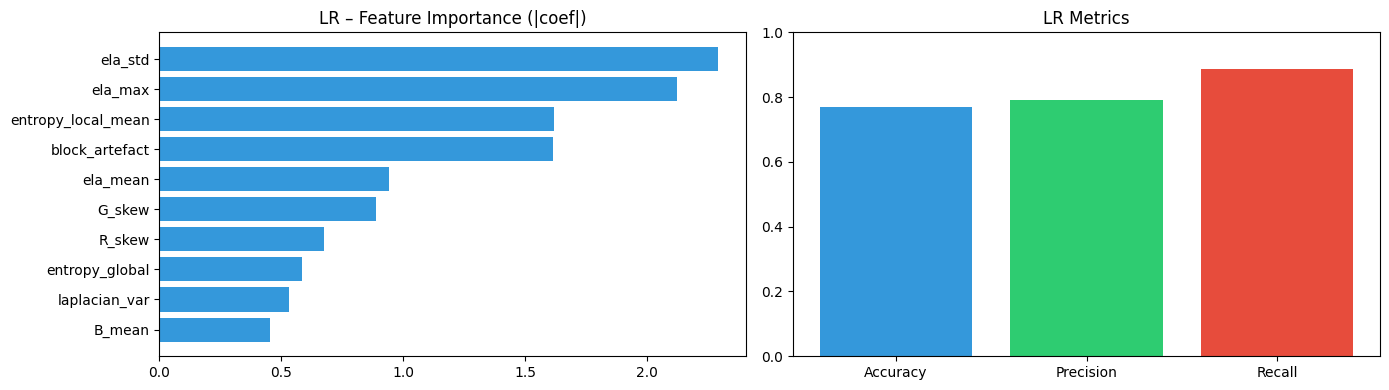

In [13]:
# ── CELL 11 │ Logistic Regression ──────────────────────────────────────────
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_val_s)

print("=== Logistic Regression ===")
print(classification_report(y_val, y_pred_lr, target_names=["Real","Fake"]))

importances_lr = np.abs(lr.coef_[0])
order = np.argsort(importances_lr)[::-1]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].barh([FEATURE_COLS[i] for i in order[:10]][::-1], importances_lr[order[:10]][::-1], color="#3498db")
axes[0].set_title("LR – Feature Importance (|coef|)")
axes[1].bar(["Accuracy","Precision","Recall"],
            [accuracy_score(y_val,y_pred_lr), precision_score(y_val,y_pred_lr), recall_score(y_val,y_pred_lr)],
            color=["#3498db","#2ecc71","#e74c3c"])
axes[1].set_ylim(0,1); axes[1].set_title("LR Metrics")
plt.tight_layout(); plt.show()

=== Random Forest ===
              precision    recall  f1-score   support

        Real       0.61      0.45      0.52        97
        Fake       0.76      0.86      0.80       194

    accuracy                           0.72       291
   macro avg       0.68      0.65      0.66       291
weighted avg       0.71      0.72      0.71       291



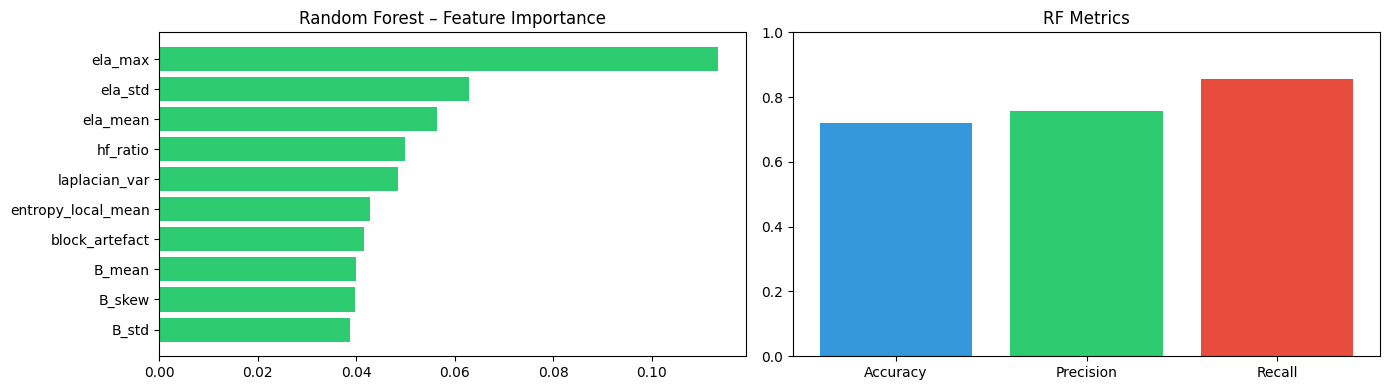

In [14]:
# ── CELL 12 │ Random Forest ─────────────────────────────────────────────────
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("=== Random Forest ===")
print(classification_report(y_val, y_pred_rf, target_names=["Real","Fake"]))

imp_rf = rf.feature_importances_
order  = np.argsort(imp_rf)[::-1]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].barh([FEATURE_COLS[i] for i in order[:10]][::-1], imp_rf[order[:10]][::-1], color="#2ecc71")
axes[0].set_title("Random Forest – Feature Importance")
axes[1].bar(["Accuracy","Precision","Recall"],
            [accuracy_score(y_val,y_pred_rf), precision_score(y_val,y_pred_rf), recall_score(y_val,y_pred_rf)],
            color=["#3498db","#2ecc71","#e74c3c"])
axes[1].set_ylim(0,1); axes[1].set_title("RF Metrics")
plt.tight_layout(); plt.show()

=== LightGBM ===
              precision    recall  f1-score   support

        Real       0.68      0.52      0.58        97
        Fake       0.78      0.88      0.83       194

    accuracy                           0.76       291
   macro avg       0.73      0.70      0.71       291
weighted avg       0.75      0.76      0.75       291



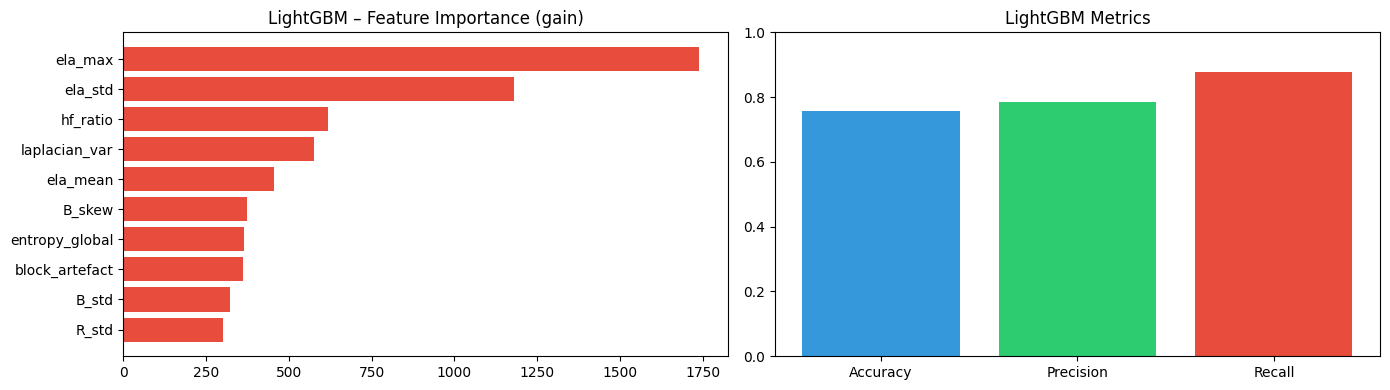

In [15]:
# ── CELL 13 │ LightGBM ──────────────────────────────────────────────────────
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val,   label=y_val, reference=lgb_train)

params = dict(objective="binary", metric="binary_logloss", learning_rate=0.05,
              num_leaves=31, n_estimators=300, verbose=-1, random_state=42)

model_lgb = lgb.train(params, lgb_train, num_boost_round=300,
                       valid_sets=[lgb_val],
                       callbacks=[lgb.early_stopping(30, verbose=False),
                                  lgb.log_evaluation(period=-1)])

y_pred_lgb = (model_lgb.predict(X_val) > 0.5).astype(int)

print("=== LightGBM ===")
print(classification_report(y_val, y_pred_lgb, target_names=["Real","Fake"]))

imp_lgb = model_lgb.feature_importance(importance_type="gain")
order   = np.argsort(imp_lgb)[::-1]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].barh([FEATURE_COLS[i] for i in order[:10]][::-1], imp_lgb[order[:10]][::-1], color="#e74c3c")
axes[0].set_title("LightGBM – Feature Importance (gain)")
axes[1].bar(["Accuracy","Precision","Recall"],
            [accuracy_score(y_val,y_pred_lgb), precision_score(y_val,y_pred_lgb), recall_score(y_val,y_pred_lgb)],
            color=["#3498db","#2ecc71","#e74c3c"])
axes[1].set_ylim(0,1); axes[1].set_title("LightGBM Metrics")
plt.tight_layout(); plt.show()

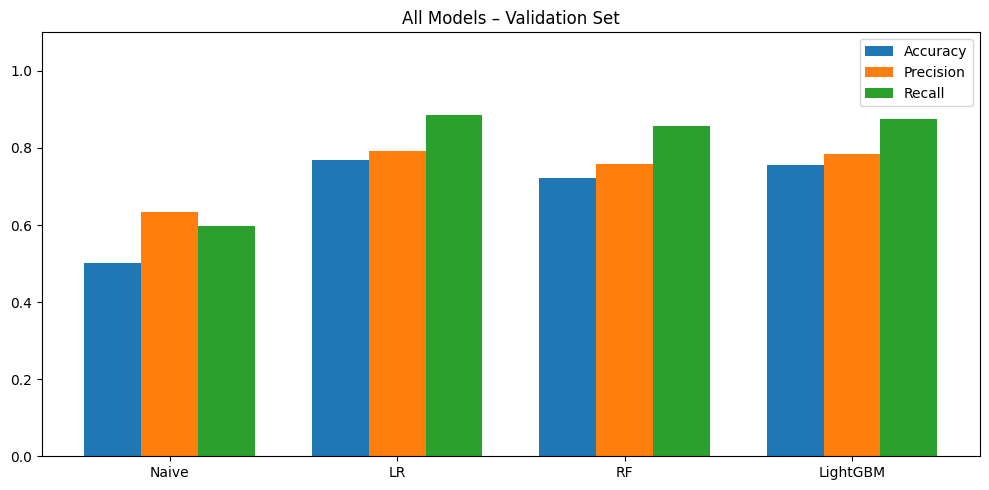

In [16]:
# ── CELL 14 │ Model comparison ──────────────────────────────────────────────
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

models = {
    "Naive":   y_pred_naive,
    "LR":      y_pred_lr,
    "RF":      y_pred_rf,
    "LightGBM":y_pred_lgb,
}

metrics = {name: {
    "Accuracy":  accuracy_score (y_val, p),
    "Precision": precision_score(y_val, p),
    "Recall":    recall_score   (y_val, p),
} for name, p in models.items()}

x = np.arange(len(models))
w = 0.25
fig, ax = plt.subplots(figsize=(10, 5))
for i, metric in enumerate(["Accuracy","Precision","Recall"]):
    vals = [metrics[m][metric] for m in models]
    ax.bar(x + i*w, vals, width=w, label=metric)
ax.set_xticks(x + w)
ax.set_xticklabels(list(models.keys()))
ax.set_ylim(0, 1.1); ax.legend(); ax.set_title("All Models – Validation Set")
plt.tight_layout(); plt.show()

Device: cuda
Epoch  20 | train 0.4226 | val 0.4481
Epoch  40 | train 0.3971 | val 0.4552
Epoch  60 | train 0.3527 | val 0.4534
Epoch  80 | train 0.3633 | val 0.4598
Epoch 100 | train 0.3415 | val 0.4647
Epoch 120 | train 0.3317 | val 0.4598
Epoch 140 | train 0.3404 | val 0.4594
Epoch 160 | train 0.3630 | val 0.4625
Epoch 180 | train 0.3492 | val 0.4591
Epoch 200 | train 0.3349 | val 0.4650


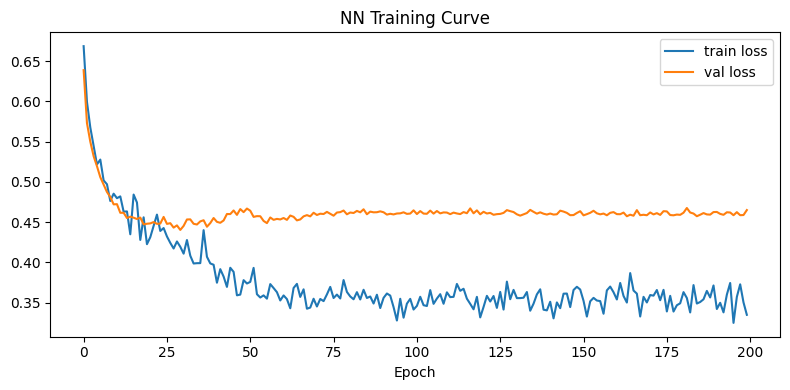

=== Neural Network ===
              precision    recall  f1-score   support

        Real       0.72      0.70      0.71        97
        Fake       0.85      0.87      0.86       194

    accuracy                           0.81       291
   macro avg       0.79      0.78      0.79       291
weighted avg       0.81      0.81      0.81       291

Accuracy:  0.811
Precision: 0.853
Recall:    0.866


In [18]:
# ── CELL 15 │ Small Neural Network ──────────────────────────────────────────
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Xtr = torch.tensor(X_train_s, dtype=torch.float32)
ytr = torch.tensor(y_train,   dtype=torch.float32)
Xvl = torch.tensor(X_val_s,   dtype=torch.float32)
yvl = torch.tensor(y_val,     dtype=torch.float32)

train_ds = TensorDataset(Xtr, ytr)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

n_feat = Xtr.shape[1]

class DetectorNN(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64),   nn.BatchNorm1d(64),  nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32),                          nn.ReLU(),
            nn.Linear(32, 1),     nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model_nn = DetectorNN(n_feat).to(device)
opt  = torch.optim.Adam(model_nn.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.BCELoss()
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=10, factor=0.5)

train_losses, val_losses = [], []
EPOCHS = 200

for epoch in range(EPOCHS):
    model_nn.train()
    ep_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model_nn(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        ep_loss += loss.item()
    train_losses.append(ep_loss / len(train_dl))

    model_nn.eval()
    with torch.no_grad():
        vl = loss_fn(model_nn(Xvl.to(device)), yvl.to(device)).item()
    val_losses.append(vl)
    sched.step(vl)
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | train {train_losses[-1]:.4f} | val {val_losses[-1]:.4f}")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(train_losses, label="train loss"); ax.plot(val_losses, label="val loss")
ax.legend(); ax.set_xlabel("Epoch"); ax.set_title("NN Training Curve")
plt.tight_layout(); plt.show()

model_nn.eval()
with torch.no_grad():
    y_pred_nn = (model_nn(Xvl.to(device)).cpu().numpy() > 0.5).astype(int)

print("=== Neural Network ===")
print(classification_report(y_val, y_pred_nn, target_names=["Real","Fake"]))
print(f"Accuracy:  {accuracy_score(y_val,y_pred_nn):.3f}")
print(f"Precision: {precision_score(y_val,y_pred_nn):.3f}")
print(f"Recall:    {recall_score(y_val,y_pred_nn):.3f}")

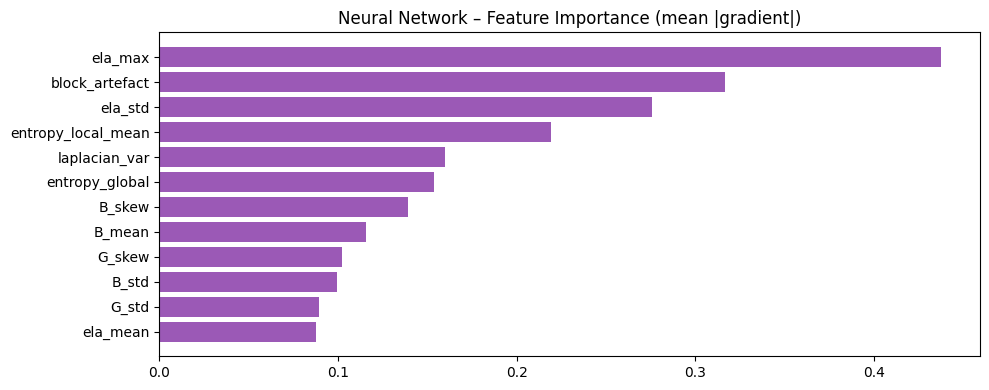

In [21]:
# ── CELL 16 │ NN – Gradient-based feature importance ────────────────────────
import torch
import numpy as np
import matplotlib.pyplot as plt

model_nn.eval()

Xvl_grad = torch.tensor(X_val_s, dtype=torch.float32).to(device)
Xvl_grad.requires_grad_(True)
Xvl_grad.retain_grad()

with torch.enable_grad():
    out = model_nn(Xvl_grad)
    out.sum().backward()

if Xvl_grad.grad is None:
    raise RuntimeError("Gradients still None — check model architecture")

importance_nn = Xvl_grad.grad.abs().mean(dim=0).cpu().numpy()

order = np.argsort(importance_nn)[::-1]
fig, ax = plt.subplots(figsize=(10, 4))
ax.barh([FEATURE_COLS[i] for i in order[:12]][::-1], importance_nn[order[:12]][::-1], color="#9b59b6")
ax.set_title("Neural Network – Feature Importance (mean |gradient|)")
plt.tight_layout(); plt.show()

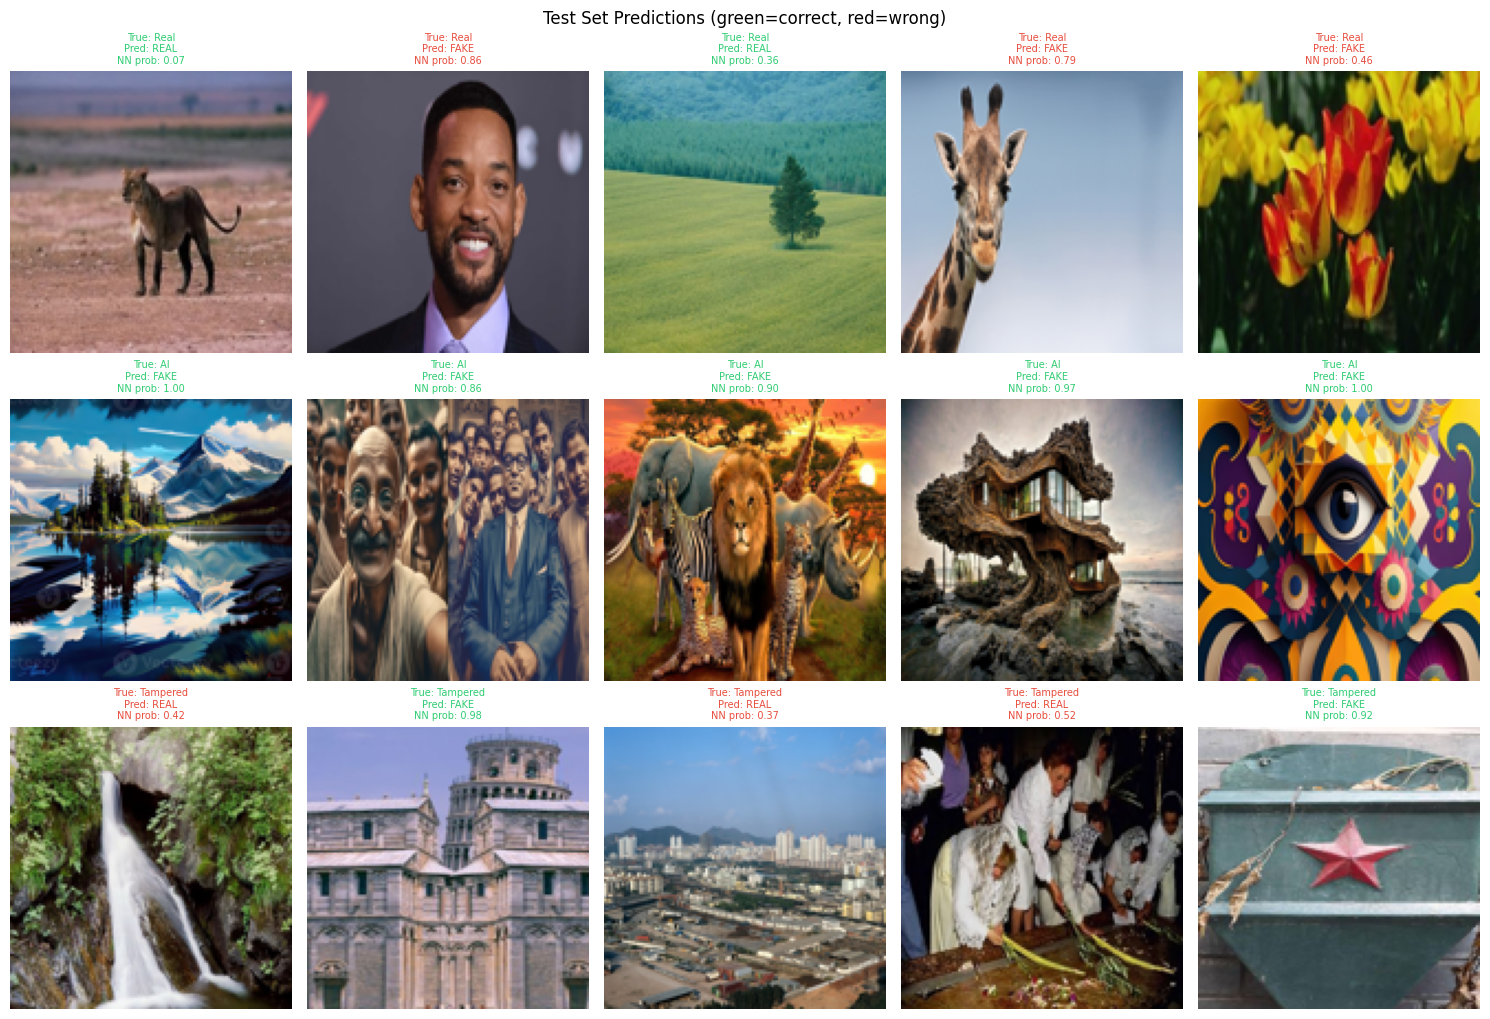


Test set  –  Accuracy: 0.600 | Precision: 0.700 | Recall: 0.700


In [23]:
# ── CELL 17 │ Evaluate on held-out test images ──────────────────────────────
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

LABEL_MAP = {"Real": 0, "AI": 1, "Tampered": 1}
COLORS = {"Real": "#2ecc71", "AI": "#3498db", "Tampered": "#e74c3c"}

def predict_image(path, threshold=0.5):
    feats = extract_features(path)
    x = np.array([feats[f] for f in FEATURE_COLS], dtype=np.float32)
    x_s = scaler.transform(x.reshape(1,-1))

    model_nn.eval()
    with torch.no_grad():
        prob_nn = model_nn(torch.tensor(x_s, dtype=torch.float32).to(device)).item()

    pred_nn = int(prob_nn > threshold)
    pred_rf = rf.predict(x.reshape(1,-1))[0]
    pred_lgb = int(model_lgb.predict(x_s)[0] > threshold)

    vote = round((pred_nn + pred_rf + pred_lgb) / 3)
    return {
        "prob_nn": prob_nn,
        "pred_nn": pred_nn,
        "pred_rf": pred_rf,
        "pred_lgb": pred_lgb,
        "ensemble": vote
    }

test_root = pathlib.Path("test_images")
results = []

for cls in ["Real", "AI", "Tampered"]:
    for p in sorted((test_root / cls).glob("*.png"))[:5]:
        true_label = LABEL_MAP[cls]
        preds = predict_image(p)
        preds["path"] = p
        preds["true_cls"] = cls
        preds["true_label"] = true_label
        results.append(preds)

# visual grid
n = len(results)
cols = 5
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3.5))
axes = axes.ravel()

for ax, r in zip(axes, results):
    img = Image.open(r["path"]).resize((128, 128))
    ax.imshow(img)
    correct = r["ensemble"] == r["true_label"]
    label_str = "FAKE" if r["ensemble"] else "REAL"
    true_str  = "FAKE" if r["true_label"] else "REAL"
    color = "#2ecc71" if correct else "#e74c3c"
    ax.set_title(f"True: {r['true_cls']}\nPred: {label_str}\nNN prob: {r['prob_nn']:.2f}",
                 fontsize=7, color=color)
    ax.axis("off")
    for spine in ax.spines.values():
        spine.set_edgecolor(color); spine.set_linewidth(3)

for ax in axes[n:]:
    ax.axis("off")

plt.suptitle("Test Set Predictions (green=correct, red=wrong)", fontsize=12)
plt.tight_layout(); plt.show()

# summary stats
y_true_test = [r["true_label"]  for r in results]
y_pred_test = [r["ensemble"]    for r in results]
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"\nTest set  –  Accuracy: {accuracy_score(y_true_test,y_pred_test):.3f} | "
      f"Precision: {precision_score(y_true_test,y_pred_test, zero_division=0):.3f} | "
      f"Recall: {recall_score(y_true_test,y_pred_test, zero_division=0):.3f}")

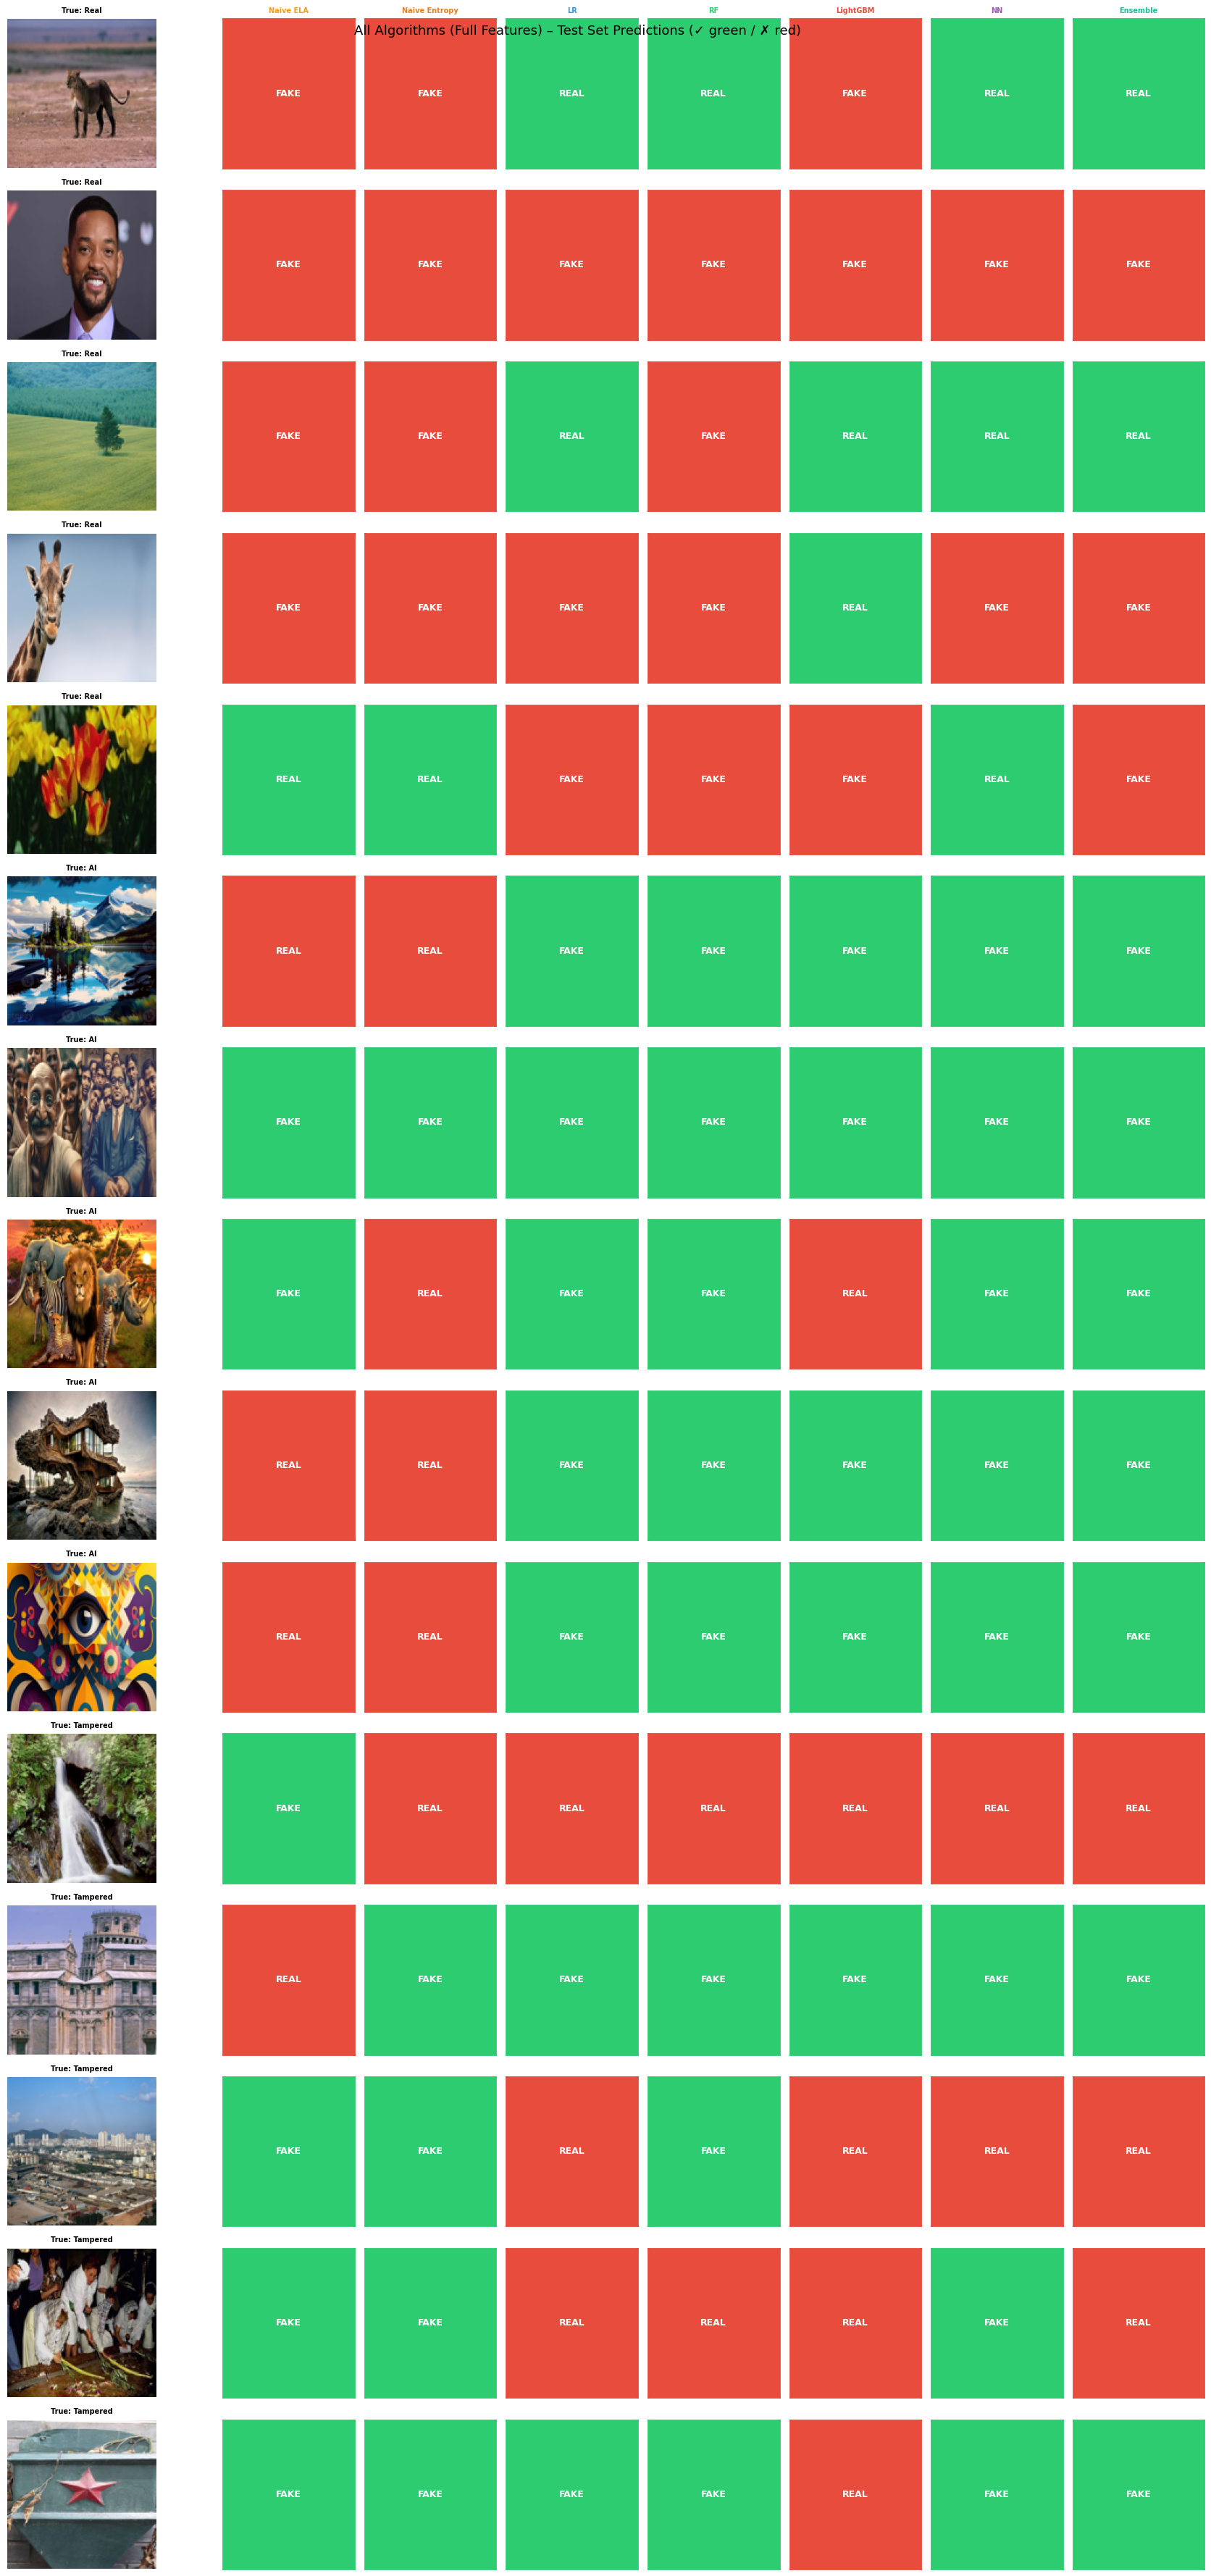


Algorithm         Accuracy  Precision   Recall  Correct
───────────────────────────────────────────────────────
Naive ELA            0.467      0.600    0.600      7/15
Naive Entropy        0.400      0.556    0.500      6/15
LR                   0.600      0.700    0.700      9/15
RF                   0.600      0.667    0.800      9/15
LightGBM             0.467      0.625    0.500      7/15
NN                   0.733      0.800    0.800     11/15
Ensemble             0.600      0.700    0.700      9/15


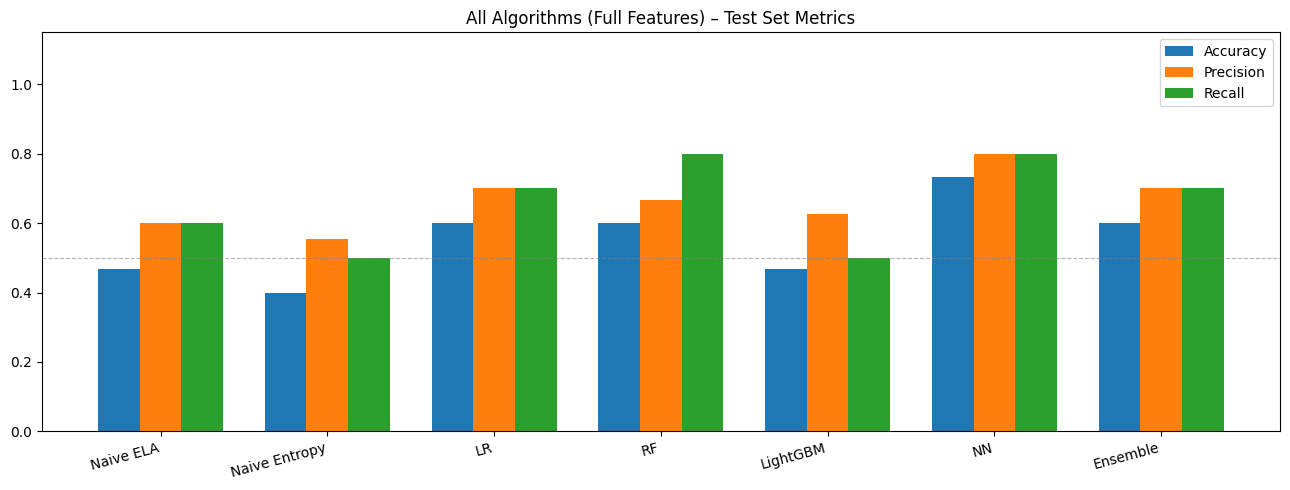

In [32]:
# ── CELL 17D │ Test Images – All Algos, Full Features ────────────────────────
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score

LABEL_MAP = {"Real": 0, "AI": 1, "Tampered": 1}

def predict_image_all_full(path, threshold=0.5):
    feats = extract_features(path)
    x      = np.array([feats[f] for f in FEATURE_COLS], dtype=np.float32)
    x_s    = scaler.transform(x.reshape(1,-1))

    # ── Naive ELA-based (Cell 10) ──────────────────────────────────────────────
    pred_naive = int(naive_predict(x.reshape(1,-1))[0])

    # ── Naive Entropy-based (Cell 10B) ────────────────────────────────────────
    pred_ent   = int(entropy_predict(x.reshape(1,-1))[0])

    # ── Logistic Regression ───────────────────────────────────────────────────
    pred_lr    = int(lr.predict(x_s)[0])

    # ── Random Forest ─────────────────────────────────────────────────────────
    pred_rf    = int(rf.predict(x.reshape(1,-1))[0])

    # ── LightGBM ──────────────────────────────────────────────────────────────
    pred_lgb   = int(model_lgb.predict(x_s)[0] > threshold)

    # ── Neural Network ────────────────────────────────────────────────────────
    model_nn.eval()
    with torch.no_grad():
        prob_nn = model_nn(torch.tensor(x_s, dtype=torch.float32).to(device)).item()
    pred_nn = int(prob_nn > threshold)

    # ── Ensemble (LR + RF + LGB + NN majority) ────────────────────────────────
    ensemble = round((pred_lr + pred_rf + pred_lgb + pred_nn) / 4)

    return {
        "Naive ELA":    pred_naive,
        "Naive Entropy":pred_ent,
        "LR":           pred_lr,
        "RF":           pred_rf,
        "LightGBM":     pred_lgb,
        "NN":           pred_nn,
        "Ensemble":     ensemble,
        "prob_nn":      prob_nn,
    }

ALGOS_FULL = ["Naive ELA", "Naive Entropy", "LR", "RF", "LightGBM", "NN", "Ensemble"]
ALGO_COLORS = {
    "Naive ELA":    "#f39c12",
    "Naive Entropy":"#e67e22",
    "LR":           "#3498db",
    "RF":           "#2ecc71",
    "LightGBM":     "#e74c3c",
    "NN":           "#9b59b6",
    "Ensemble":     "#1abc9c",
}

test_root      = pathlib.Path("test_images")
results_full   = []

for cls in ["Real", "AI", "Tampered"]:
    for p in sorted((test_root / cls).glob("*.png"))[:5]:
        preds = predict_image_all_full(p)
        preds["path"]       = p
        preds["true_cls"]   = cls
        preds["true_label"] = LABEL_MAP[cls]
        results_full.append(preds)

# ── Visual grid ───────────────────────────────────────────────────────────────
n_imgs = len(results_full)
n_algo = len(ALGOS_FULL)

fig, axes = plt.subplots(n_imgs, n_algo + 1,
                         figsize=((n_algo + 1) * 2.2, n_imgs * 2.4),
                         gridspec_kw={"width_ratios": [2] + [1]*n_algo})
fig.suptitle("All Algorithms (Full Features) – Test Set Predictions (✓ green / ✗ red)", fontsize=13)

for row, r in enumerate(results_full):
    img = Image.open(r["path"]).resize((128, 128))
    axes[row, 0].imshow(img)
    axes[row, 0].set_title(f"True: {r['true_cls']}", fontsize=7, fontweight="bold")
    axes[row, 0].axis("off")

    for col, algo in enumerate(ALGOS_FULL, start=1):
        pred    = r[algo]
        correct = pred == r["true_label"]
        label   = "FAKE" if pred else "REAL"
        color   = "#2ecc71" if correct else "#e74c3c"
        ax      = axes[row, col]

        ax.set_facecolor(color)
        ax.text(0.5, 0.5, label, ha="center", va="center",
                fontsize=9, fontweight="bold", color="white",
                transform=ax.transAxes)
        if row == 0:
            ax.set_title(algo, fontsize=7, color=ALGO_COLORS[algo], fontweight="bold")
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor(color); spine.set_linewidth(2)

plt.tight_layout(); plt.show()

# ── Per-algo metrics table ────────────────────────────────────────────────────
y_true = [r["true_label"] for r in results_full]

print(f"\n{'Algorithm':<16} {'Accuracy':>9} {'Precision':>10} {'Recall':>8} {'Correct':>8}")
print("─" * 55)
for algo in ALGOS_FULL:
    y_pred = [r[algo] for r in results_full]
    acc  = accuracy_score (y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score   (y_true, y_pred, zero_division=0)
    n_ok = sum(p==t for p,t in zip(y_pred, y_true))
    print(f"{algo:<16} {acc:>9.3f} {prec:>10.3f} {rec:>8.3f} {n_ok:>6}/{len(y_true)}")

# ── Grouped bar chart ─────────────────────────────────────────────────────────
metrics_by_algo = {}
for algo in ALGOS_FULL:
    y_pred = [r[algo] for r in results_full]
    metrics_by_algo[algo] = [
        accuracy_score (y_true, y_pred),
        precision_score(y_true, y_pred, zero_division=0),
        recall_score   (y_true, y_pred, zero_division=0),
    ]

x  = np.arange(len(ALGOS_FULL))
w  = 0.25
fig, ax = plt.subplots(figsize=(13, 5))
for i, (metric, offset) in enumerate(zip(["Accuracy","Precision","Recall"], [-w, 0, w])):
    vals = [metrics_by_algo[a][i] for a in ALGOS_FULL]
    ax.bar(x + offset, vals, width=w, label=metric)

ax.set_xticks(x)
ax.set_xticklabels(ALGOS_FULL, rotation=15, ha="right")
ax.set_ylim(0, 1.15); ax.legend()
ax.set_title("All Algorithms (Full Features) – Test Set Metrics")
ax.axhline(0.5, color="gray", linestyle="--", linewidth=0.8, alpha=0.6)
plt.tight_layout(); plt.show()

## Top-5 Feature Subset — Formulas

**ELA Max** (`ela_max`)  
Recompress image at quality $q=75$, compute absolute pixel difference $D = |I - I_q|$, then:
$$\text{ELA\_max} = \max_{i,j,c}\ D_{i,j,c}$$
Tampered and AI regions recompress differently from authentic areas, producing high peaks.

**ELA Std** (`ela_std`)  
$$\text{ELA\_std} = \sqrt{\frac{1}{N}\sum_{i,j,c}\left(D_{i,j,c} - \bar{D}\right)^2}$$
High variance in the error map indicates spatially inconsistent compression history — a hallmark of splicing.

**High-Frequency Power Ratio** (`hf_ratio`)  
Let $F = \mathcal{F}(I_\text{gray})$ be the 2D FFT, $M = |F|$ the magnitude spectrum, $M_\text{low}$ the central $r \times r$ low-frequency region ($r = \min(H,W)/4$):
$$\text{HF\_ratio} = \frac{\sum M_\text{high}}{\sum M} = \frac{\sum M - \sum M_\text{low}}{\sum M}$$
AI-generated images tend to have an unnaturally flat or boosted high-frequency spectrum.

**Local Entropy Mean** (`entropy_local_mean`)  
Using a disk-shaped neighbourhood $\mathcal{N}$ of radius 5:
$$H_\text{local}(i,j) = -\sum_{k=0}^{255} p_k^{(i,j)} \log_2 p_k^{(i,j)}$$
$$\text{entropy\_local\_mean} = \frac{1}{HW}\sum_{i,j} H_\text{local}(i,j)$$
Tampered patches break the spatial homogeneity of local texture complexity.

**Laplacian Variance** (`laplacian_var`)  
$$\nabla^2 I = I * \begin{bmatrix}0&1&0\\1&-4&1\\0&1&0\end{bmatrix}$$
$$\text{laplacian\_var} = \text{Var}(\nabla^2 I_\text{gray})$$
Measures sharpness and noise level — real camera images have a characteristic noise signature absent in AI outputs.

=== Logistic Regression – Top-5 Features ===
              precision    recall  f1-score   support

        Real       0.59      0.36      0.45        97
        Fake       0.73      0.88      0.80       194

    accuracy                           0.70       291
   macro avg       0.66      0.62      0.62       291
weighted avg       0.69      0.70      0.68       291



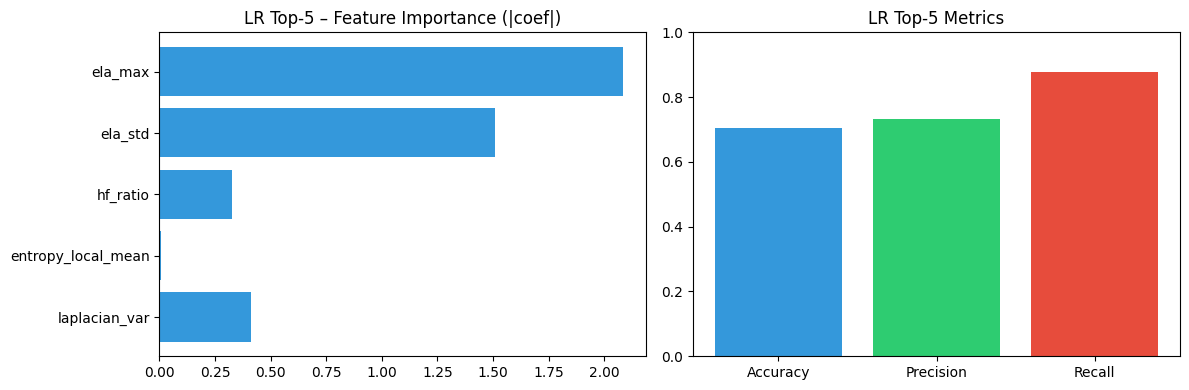

In [24]:
# ── CELL 11B │ Logistic Regression – Top-5 Features ──────────────────────────
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

TOP5 = ["ela_max", "ela_std", "hf_ratio", "entropy_local_mean", "laplacian_var"]
top5_idx = [FEATURE_COLS.index(f) for f in TOP5]

X_train_t5 = X_train[:, top5_idx]
X_val_t5   = X_val[:,   top5_idx]

scaler_t5 = StandardScaler()
X_train_t5s = scaler_t5.fit_transform(X_train_t5)
X_val_t5s   = scaler_t5.transform(X_val_t5)

lr_t5 = LogisticRegression(max_iter=1000, random_state=42)
lr_t5.fit(X_train_t5s, y_train)
y_pred_lr_t5 = lr_t5.predict(X_val_t5s)

print("=== Logistic Regression – Top-5 Features ===")
print(classification_report(y_val, y_pred_lr_t5, target_names=["Real","Fake"]))

importances_lr_t5 = np.abs(lr_t5.coef_[0])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].barh(TOP5[::-1], importances_lr_t5[::-1], color="#3498db")
axes[0].set_title("LR Top-5 – Feature Importance (|coef|)")
axes[1].bar(["Accuracy","Precision","Recall"],
            [accuracy_score(y_val,y_pred_lr_t5), precision_score(y_val,y_pred_lr_t5), recall_score(y_val,y_pred_lr_t5)],
            color=["#3498db","#2ecc71","#e74c3c"])
axes[1].set_ylim(0,1); axes[1].set_title("LR Top-5 Metrics")
plt.tight_layout(); plt.show()

=== Random Forest – Top-5 Features ===
              precision    recall  f1-score   support

        Real       0.62      0.54      0.57        97
        Fake       0.78      0.84      0.81       194

    accuracy                           0.74       291
   macro avg       0.70      0.69      0.69       291
weighted avg       0.73      0.74      0.73       291



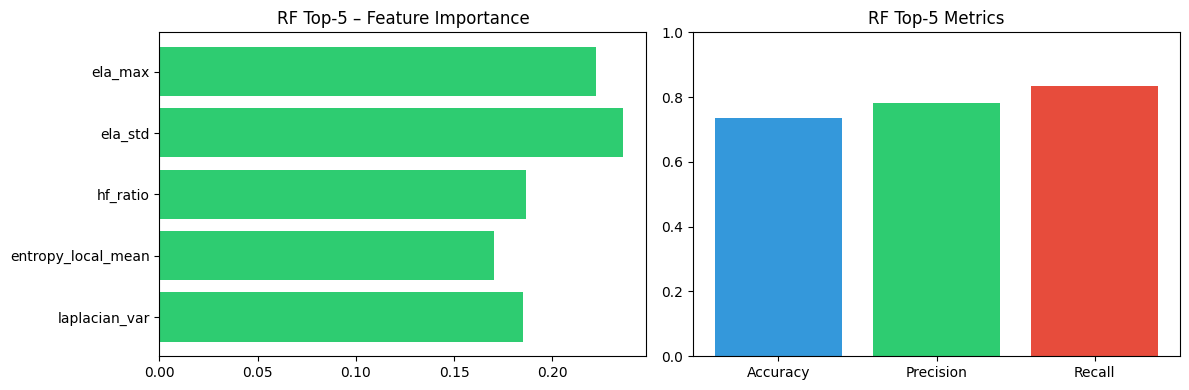

In [25]:
# ── CELL 12B │ Random Forest – Top-5 Features ────────────────────────────────
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

rf_t5 = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_t5.fit(X_train_t5, y_train)
y_pred_rf_t5 = rf_t5.predict(X_val_t5)

print("=== Random Forest – Top-5 Features ===")
print(classification_report(y_val, y_pred_rf_t5, target_names=["Real","Fake"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].barh(TOP5[::-1], rf_t5.feature_importances_[::-1], color="#2ecc71")
axes[0].set_title("RF Top-5 – Feature Importance")
axes[1].bar(["Accuracy","Precision","Recall"],
            [accuracy_score(y_val,y_pred_rf_t5), precision_score(y_val,y_pred_rf_t5), recall_score(y_val,y_pred_rf_t5)],
            color=["#3498db","#2ecc71","#e74c3c"])
axes[1].set_ylim(0,1); axes[1].set_title("RF Top-5 Metrics")
plt.tight_layout(); plt.show()

=== LightGBM – Top-5 Features ===
              precision    recall  f1-score   support

        Real       0.60      0.52      0.56        97
        Fake       0.77      0.83      0.80       194

    accuracy                           0.73       291
   macro avg       0.69      0.67      0.68       291
weighted avg       0.72      0.73      0.72       291



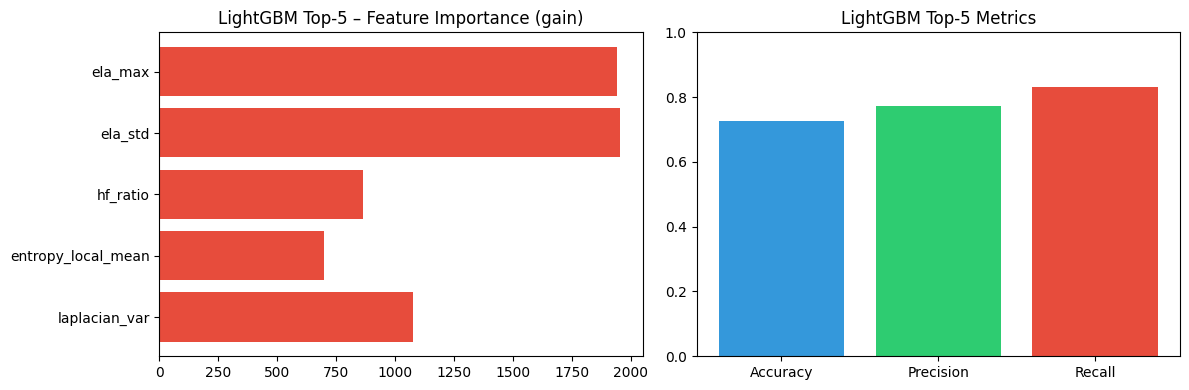

In [26]:
# ── CELL 13B │ LightGBM – Top-5 Features ─────────────────────────────────────
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

lgb_train_t5 = lgb.Dataset(X_train_t5s, label=y_train)
lgb_val_t5   = lgb.Dataset(X_val_t5s,   label=y_val, reference=lgb_train_t5)

params = dict(objective="binary", metric="binary_logloss", learning_rate=0.05,
              num_leaves=31, verbose=-1, random_state=42)

model_lgb_t5 = lgb.train(params, lgb_train_t5, num_boost_round=300,
                          valid_sets=[lgb_val_t5],
                          callbacks=[lgb.early_stopping(30, verbose=False),
                                     lgb.log_evaluation(period=-1)])

y_pred_lgb_t5 = (model_lgb_t5.predict(X_val_t5s) > 0.5).astype(int)

print("=== LightGBM – Top-5 Features ===")
print(classification_report(y_val, y_pred_lgb_t5, target_names=["Real","Fake"]))

imp_lgb_t5 = model_lgb_t5.feature_importance(importance_type="gain")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].barh(TOP5[::-1], imp_lgb_t5[::-1], color="#e74c3c")
axes[0].set_title("LightGBM Top-5 – Feature Importance (gain)")
axes[1].bar(["Accuracy","Precision","Recall"],
            [accuracy_score(y_val,y_pred_lgb_t5), precision_score(y_val,y_pred_lgb_t5), recall_score(y_val,y_pred_lgb_t5)],
            color=["#3498db","#2ecc71","#e74c3c"])
axes[1].set_ylim(0,1); axes[1].set_title("LightGBM Top-5 Metrics")
plt.tight_layout(); plt.show()

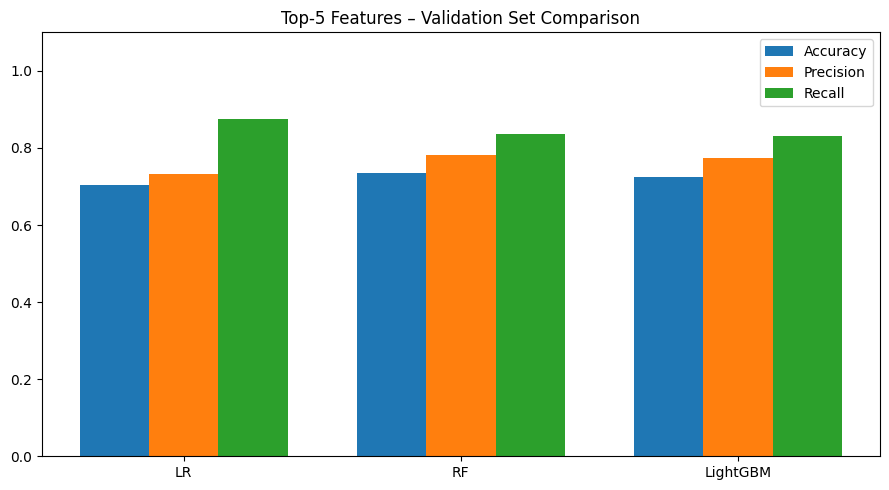

In [27]:
# ── CELL 14B │ Model Comparison – Top-5 Features ─────────────────────────────
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

models_t5 = {
    "LR":       y_pred_lr_t5,
    "RF":       y_pred_rf_t5,
    "LightGBM": y_pred_lgb_t5,
}

metrics_t5 = {name: {
    "Accuracy":  accuracy_score (y_val, p),
    "Precision": precision_score(y_val, p),
    "Recall":    recall_score   (y_val, p),
} for name, p in models_t5.items()}

x = np.arange(len(models_t5))
w = 0.25
fig, ax = plt.subplots(figsize=(9, 5))
for i, metric in enumerate(["Accuracy","Precision","Recall"]):
    vals = [metrics_t5[m][metric] for m in models_t5]
    ax.bar(x + i*w, vals, width=w, label=metric)
ax.set_xticks(x + w)
ax.set_xticklabels(list(models_t5.keys()))
ax.set_ylim(0, 1.1); ax.legend(); ax.set_title("Top-5 Features – Validation Set Comparison")
plt.tight_layout(); plt.show()

Epoch  20 | train 0.5160 | val 0.5052
Epoch  40 | train 0.4938 | val 0.4935
Epoch  60 | train 0.5003 | val 0.4979
Epoch  80 | train 0.4852 | val 0.4986
Epoch 100 | train 0.4831 | val 0.4988
Epoch 120 | train 0.4953 | val 0.4928
Epoch 140 | train 0.4812 | val 0.4948
Epoch 160 | train 0.4870 | val 0.4968
Epoch 180 | train 0.4980 | val 0.4948
Epoch 200 | train 0.5006 | val 0.4948


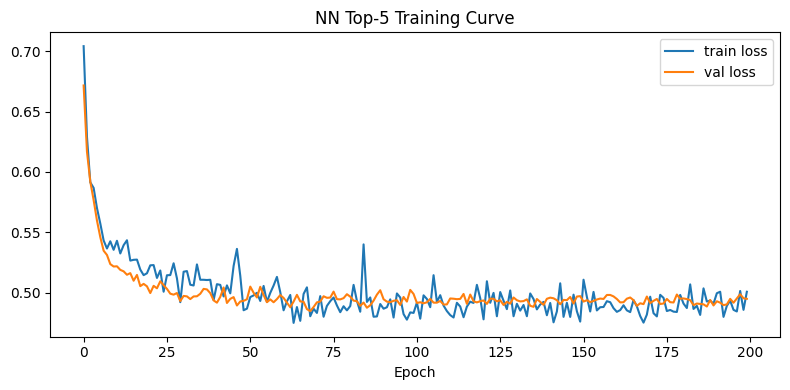

=== Neural Network – Top-5 Features ===
              precision    recall  f1-score   support

        Real       0.66      0.59      0.62        97
        Fake       0.80      0.85      0.83       194

    accuracy                           0.76       291
   macro avg       0.73      0.72      0.73       291
weighted avg       0.76      0.76      0.76       291

Accuracy:  0.763
Precision: 0.805
Recall:    0.851


In [28]:
# ── CELL 15B │ Neural Network – Top-5 Features ───────────────────────────────
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"

Xtr_t5 = torch.tensor(X_train_t5s, dtype=torch.float32)
ytr_t5 = torch.tensor(y_train,     dtype=torch.float32)
Xvl_t5 = torch.tensor(X_val_t5s,   dtype=torch.float32)
yvl_t5 = torch.tensor(y_val,       dtype=torch.float32)

train_dl_t5 = DataLoader(TensorDataset(Xtr_t5, ytr_t5), batch_size=64, shuffle=True)

class DetectorNN_T5(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64),  nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 32),                      nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 16),                      nn.ReLU(),
            nn.Linear(16, 1),  nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model_nn_t5 = DetectorNN_T5().to(device)
opt_t5    = torch.optim.Adam(model_nn_t5.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn   = nn.BCELoss()
sched_t5  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_t5, patience=10, factor=0.5)

train_losses_t5, val_losses_t5 = [], []
EPOCHS = 200

for epoch in range(EPOCHS):
    model_nn_t5.train()
    ep_loss = 0
    for xb, yb in train_dl_t5:
        xb, yb = xb.to(device), yb.to(device)
        opt_t5.zero_grad()
        loss = loss_fn(model_nn_t5(xb), yb)
        loss.backward()
        opt_t5.step()
        ep_loss += loss.item()
    train_losses_t5.append(ep_loss / len(train_dl_t5))

    model_nn_t5.eval()
    with torch.no_grad():
        vl = loss_fn(model_nn_t5(Xvl_t5.to(device)), yvl_t5.to(device)).item()
    val_losses_t5.append(vl)
    sched_t5.step(vl)
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | train {train_losses_t5[-1]:.4f} | val {val_losses_t5[-1]:.4f}")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(train_losses_t5, label="train loss"); ax.plot(val_losses_t5, label="val loss")
ax.legend(); ax.set_xlabel("Epoch"); ax.set_title("NN Top-5 Training Curve")
plt.tight_layout(); plt.show()

model_nn_t5.eval()
with torch.no_grad():
    y_pred_nn_t5 = (model_nn_t5(Xvl_t5.to(device)).cpu().numpy() > 0.5).astype(int)

print("=== Neural Network – Top-5 Features ===")
print(classification_report(y_val, y_pred_nn_t5, target_names=["Real","Fake"]))
print(f"Accuracy:  {accuracy_score(y_val,y_pred_nn_t5):.3f}")
print(f"Precision: {precision_score(y_val,y_pred_nn_t5):.3f}")
print(f"Recall:    {recall_score(y_val,y_pred_nn_t5):.3f}")

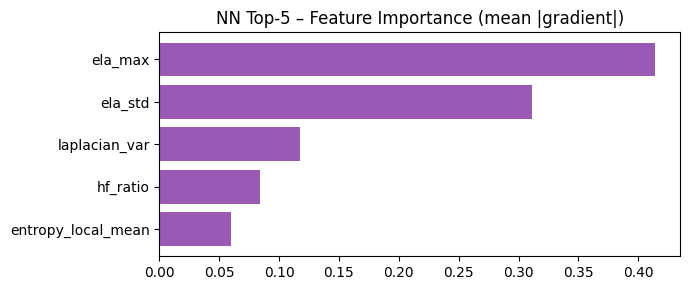

In [29]:
# ── CELL 16B │ NN Top-5 – Gradient-based Feature Importance ──────────────────
import torch
import numpy as np
import matplotlib.pyplot as plt

model_nn_t5.eval()

Xvl_grad_t5 = torch.tensor(X_val_t5s, dtype=torch.float32).to(device)
Xvl_grad_t5.requires_grad_(True)
Xvl_grad_t5.retain_grad()

with torch.enable_grad():
    out_t5 = model_nn_t5(Xvl_grad_t5)
    out_t5.sum().backward()

importance_nn_t5 = Xvl_grad_t5.grad.abs().mean(dim=0).cpu().numpy()

order_t5 = np.argsort(importance_nn_t5)[::-1]
fig, ax = plt.subplots(figsize=(7, 3))
ax.barh([TOP5[i] for i in order_t5][::-1], importance_nn_t5[order_t5][::-1], color="#9b59b6")
ax.set_title("NN Top-5 – Feature Importance (mean |gradient|)")
plt.tight_layout(); plt.show()

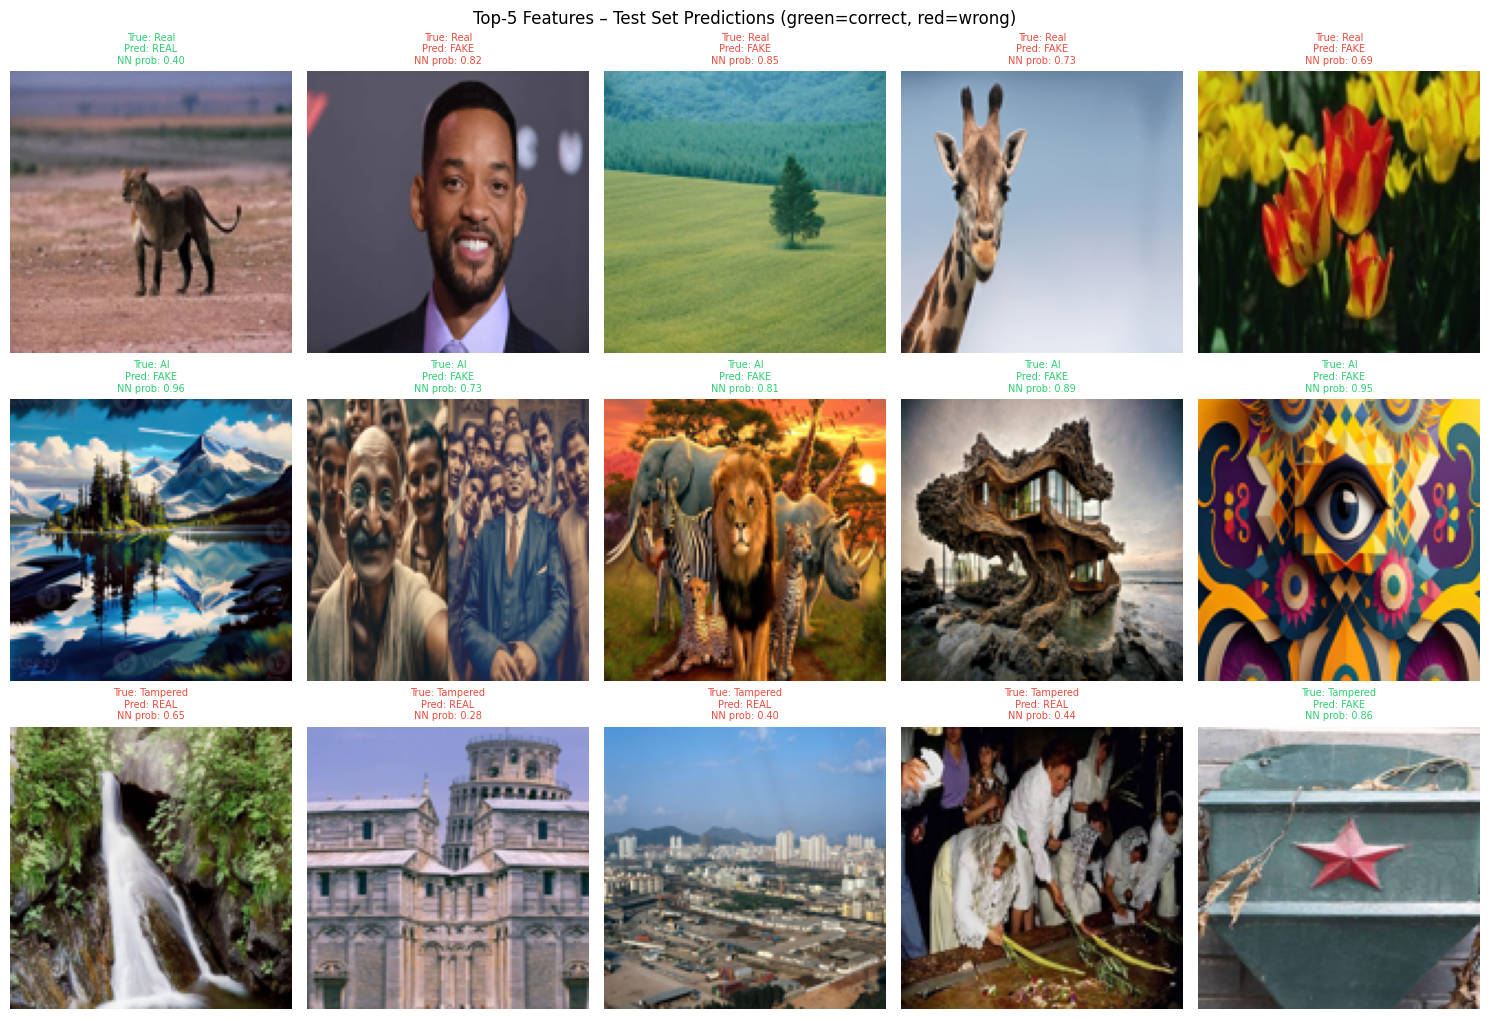


Top-5 Test Set – Accuracy: 0.467 | Precision: 0.600 | Recall: 0.600


In [30]:
# ── CELL 17B │ Test Images – Top-5 Feature Models ────────────────────────────
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

LABEL_MAP = {"Real": 0, "AI": 1, "Tampered": 1}

def predict_image_t5(path, threshold=0.5):
    feats = extract_features(path)
    x_t5  = np.array([feats[f] for f in TOP5], dtype=np.float32)
    x_t5s = scaler_t5.transform(x_t5.reshape(1,-1))

    model_nn_t5.eval()
    with torch.no_grad():
        prob_nn = model_nn_t5(torch.tensor(x_t5s, dtype=torch.float32).to(device)).item()

    pred_nn  = int(prob_nn > threshold)
    pred_rf  = rf_t5.predict(x_t5.reshape(1,-1))[0]
    pred_lgb = int(model_lgb_t5.predict(x_t5s)[0] > threshold)
    vote     = round((pred_nn + pred_rf + pred_lgb) / 3)

    return {"prob_nn": prob_nn, "pred_nn": pred_nn,
            "pred_rf": pred_rf, "pred_lgb": pred_lgb, "ensemble": vote}

test_root = pathlib.Path("test_images")
results_t5 = []

for cls in ["Real", "AI", "Tampered"]:
    for p in sorted((test_root / cls).glob("*.png"))[:5]:
        preds = predict_image_t5(p)
        preds["path"] = p
        preds["true_cls"]   = cls
        preds["true_label"] = LABEL_MAP[cls]
        results_t5.append(preds)

n    = len(results_t5)
cols = 5
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3.5))
axes = axes.ravel()

for ax, r in zip(axes, results_t5):
    img = Image.open(r["path"]).resize((128,128))
    ax.imshow(img)
    correct    = r["ensemble"] == r["true_label"]
    label_str  = "FAKE" if r["ensemble"] else "REAL"
    color      = "#2ecc71" if correct else "#e74c3c"
    ax.set_title(f"True: {r['true_cls']}\nPred: {label_str}\nNN prob: {r['prob_nn']:.2f}",
                 fontsize=7, color=color)
    ax.axis("off")
    for spine in ax.spines.values():
        spine.set_edgecolor(color); spine.set_linewidth(3)

for ax in axes[n:]:
    ax.axis("off")

plt.suptitle("Top-5 Features – Test Set Predictions (green=correct, red=wrong)", fontsize=12)
plt.tight_layout(); plt.show()

y_true_t5 = [r["true_label"] for r in results_t5]
y_pred_t5 = [r["ensemble"]   for r in results_t5]
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"\nTop-5 Test Set – Accuracy: {accuracy_score(y_true_t5,y_pred_t5):.3f} | "
      f"Precision: {precision_score(y_true_t5,y_pred_t5, zero_division=0):.3f} | "
      f"Recall: {recall_score(y_true_t5,y_pred_t5, zero_division=0):.3f}")

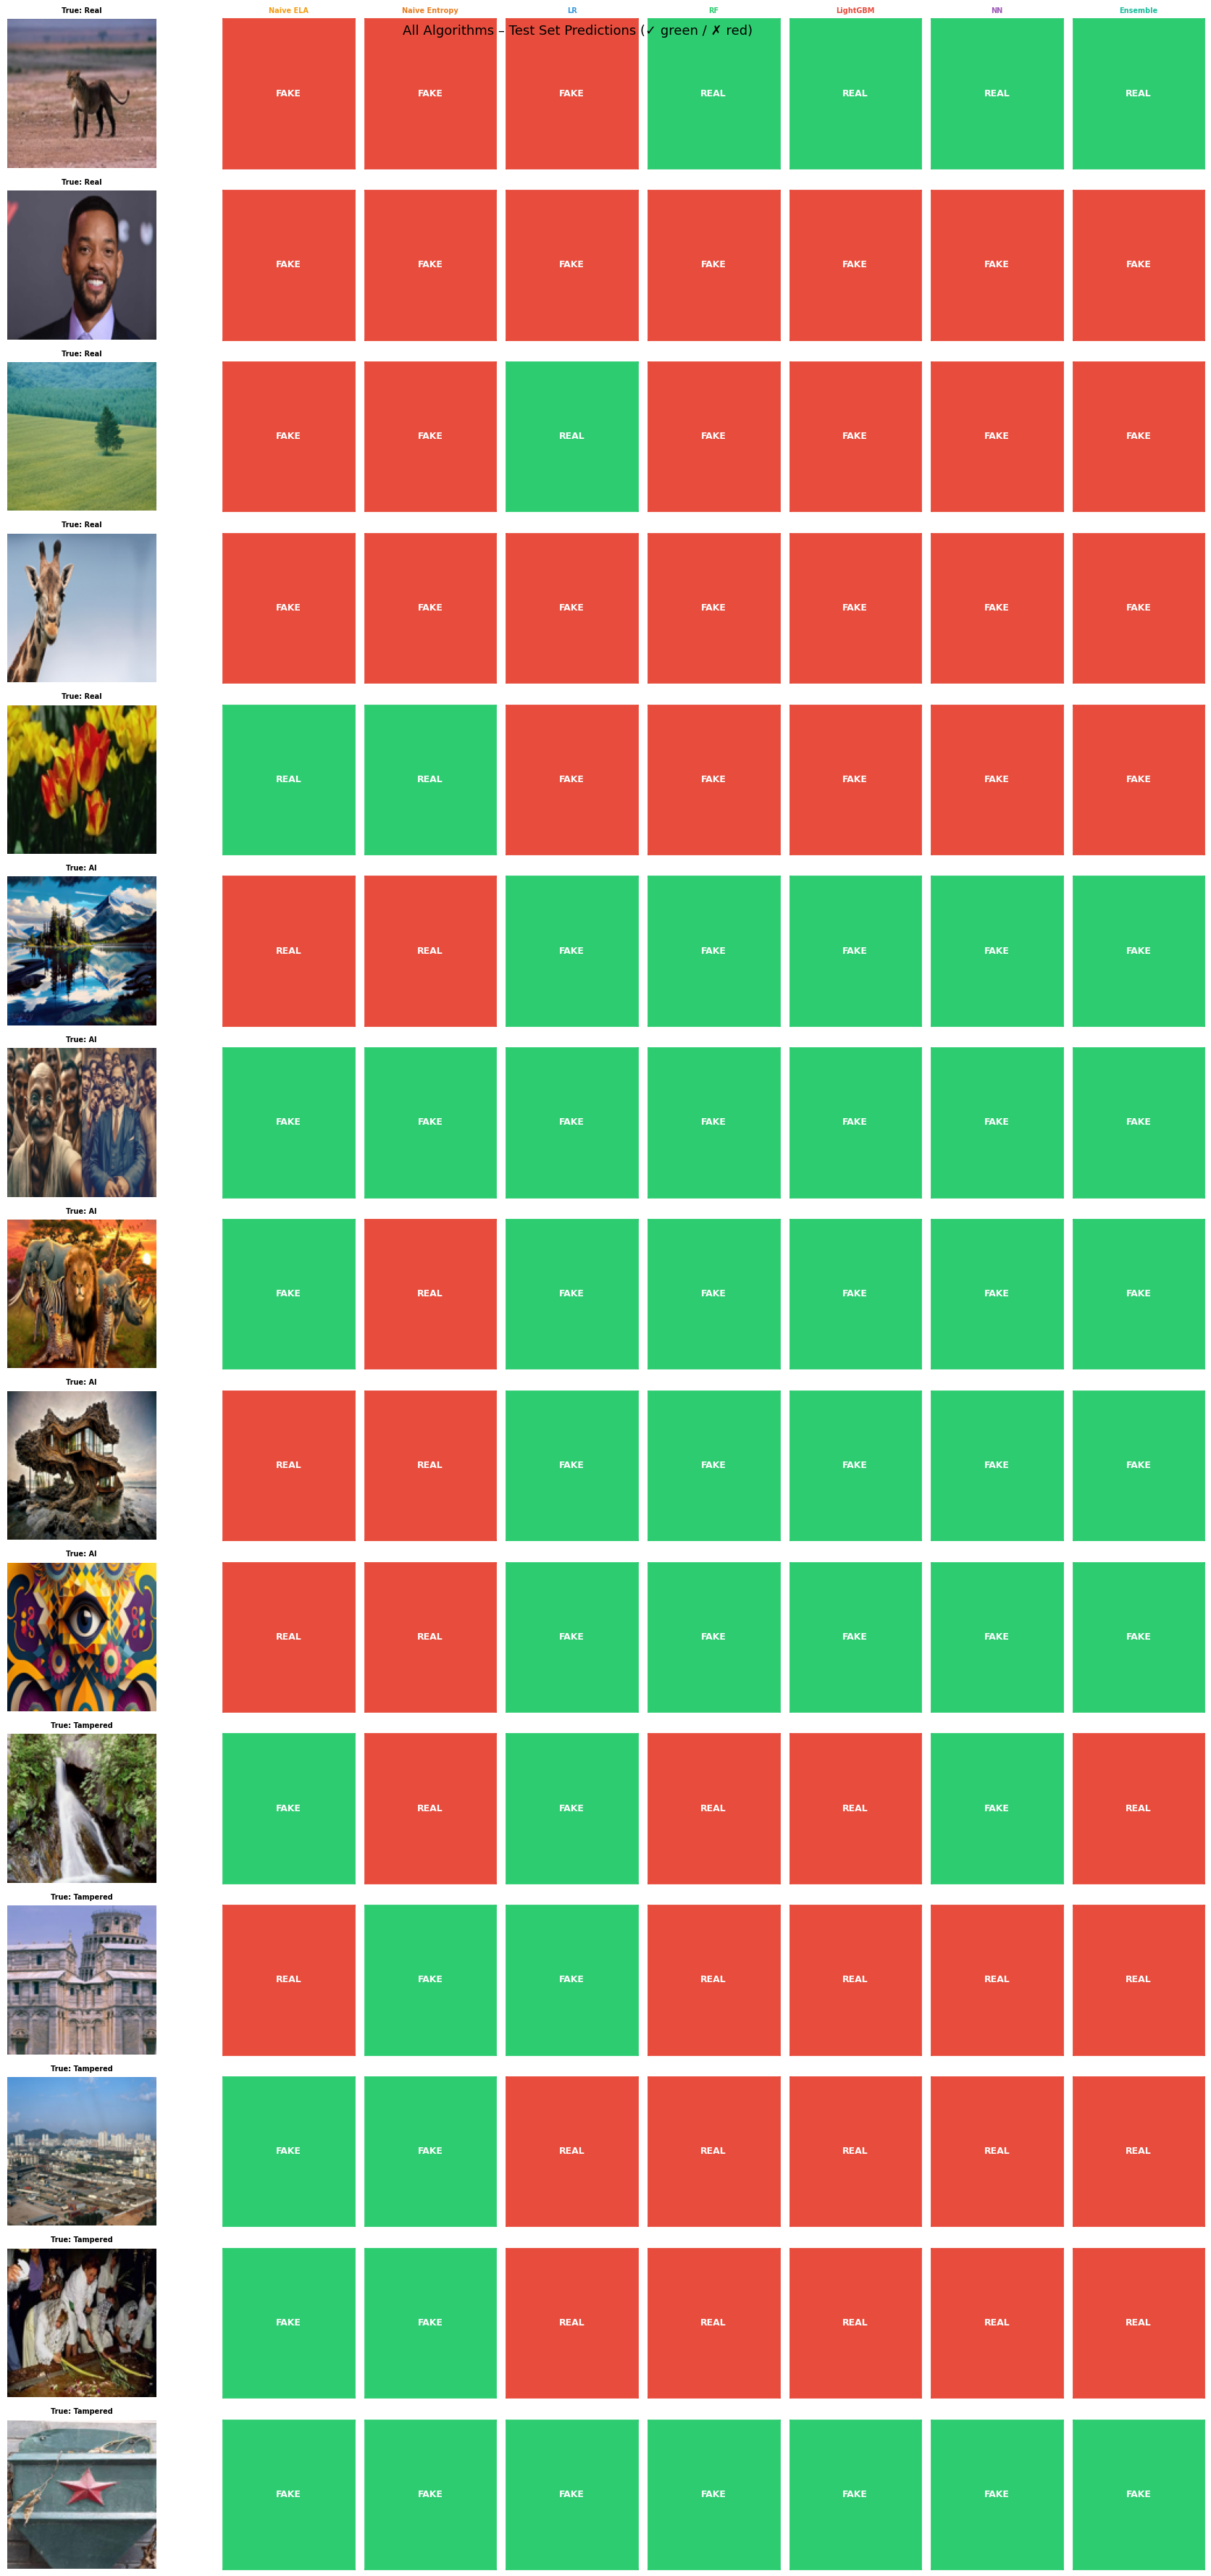


Algorithm         Accuracy  Precision   Recall  Correct
───────────────────────────────────────────────────────
Naive ELA            0.467      0.600    0.600      7/15
Naive Entropy        0.400      0.556    0.500      6/15
LR                   0.600      0.667    0.800      9/15
RF                   0.467      0.600    0.600      7/15
LightGBM             0.467      0.600    0.600      7/15
NN                   0.533      0.636    0.700      8/15
Ensemble             0.467      0.600    0.600      7/15


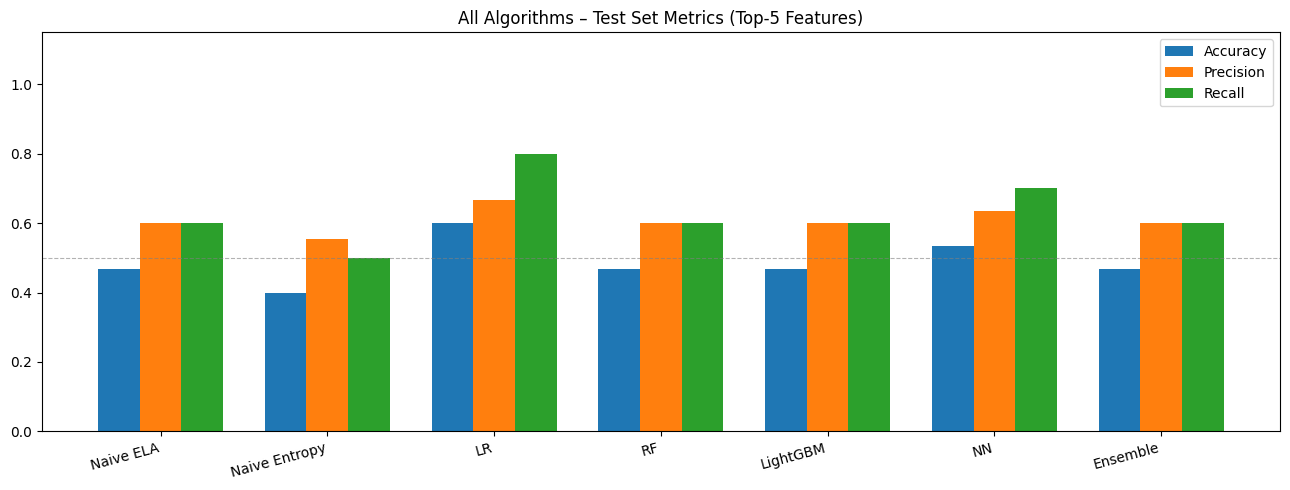

In [31]:
# ── CELL 17C │ Test Images – All Algos, Top-5 Features ───────────────────────
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score

LABEL_MAP = {"Real": 0, "AI": 1, "Tampered": 1}

def predict_image_all(path, threshold=0.5):
    feats = extract_features(path)

    # full feature vector (for naive + full-feature models if needed)
    x_full  = np.array([feats[f] for f in FEATURE_COLS], dtype=np.float32)

    # top-5 vector
    x_t5    = np.array([feats[f] for f in TOP5], dtype=np.float32)
    x_t5s   = scaler_t5.transform(x_t5.reshape(1,-1))

    # ── Naive ELA-based (Cell 10) ──────────────────────────────────────────────
    pred_naive = int(naive_predict(x_full.reshape(1,-1))[0])

    # ── Naive Entropy-based (Cell 10B) ────────────────────────────────────────
    pred_ent   = int(entropy_predict(x_full.reshape(1,-1))[0])

    # ── Logistic Regression ───────────────────────────────────────────────────
    pred_lr    = int(lr_t5.predict(x_t5s)[0])

    # ── Random Forest ─────────────────────────────────────────────────────────
    pred_rf    = int(rf_t5.predict(x_t5.reshape(1,-1))[0])

    # ── LightGBM ──────────────────────────────────────────────────────────────
    pred_lgb   = int(model_lgb_t5.predict(x_t5s)[0] > threshold)

    # ── Neural Network ────────────────────────────────────────────────────────
    model_nn_t5.eval()
    with torch.no_grad():
        prob_nn = model_nn_t5(torch.tensor(x_t5s, dtype=torch.float32).to(device)).item()
    pred_nn = int(prob_nn > threshold)

    # ── Ensemble (LR + RF + LGB + NN majority) ────────────────────────────────
    ensemble = round((pred_lr + pred_rf + pred_lgb + pred_nn) / 4)

    return {
        "Naive ELA":    pred_naive,
        "Naive Entropy":pred_ent,
        "LR":           pred_lr,
        "RF":           pred_rf,
        "LightGBM":     pred_lgb,
        "NN":           pred_nn,
        "Ensemble":     ensemble,
        "prob_nn":      prob_nn,
    }

ALGOS = ["Naive ELA", "Naive Entropy", "LR", "RF", "LightGBM", "NN", "Ensemble"]
ALGO_COLORS = {
    "Naive ELA":    "#f39c12",
    "Naive Entropy":"#e67e22",
    "LR":           "#3498db",
    "RF":           "#2ecc71",
    "LightGBM":     "#e74c3c",
    "NN":           "#9b59b6",
    "Ensemble":     "#1abc9c",
}

test_root  = pathlib.Path("test_images")
results_all = []

for cls in ["Real", "AI", "Tampered"]:
    for p in sorted((test_root / cls).glob("*.png"))[:5]:
        preds = predict_image_all(p)
        preds["path"]       = p
        preds["true_cls"]   = cls
        preds["true_label"] = LABEL_MAP[cls]
        results_all.append(preds)

# ── Visual grid: one row per image, columns = algos ──────────────────────────
n_imgs = len(results_all)
n_algo = len(ALGOS)

fig, axes = plt.subplots(n_imgs, n_algo + 1,
                         figsize=((n_algo + 1) * 2.2, n_imgs * 2.4),
                         gridspec_kw={"width_ratios": [2] + [1]*n_algo})
fig.suptitle("All Algorithms – Test Set Predictions (✓ green / ✗ red)", fontsize=13)

for row, r in enumerate(results_all):
    # thumbnail
    img = Image.open(r["path"]).resize((128, 128))
    axes[row, 0].imshow(img)
    axes[row, 0].set_title(f"True: {r['true_cls']}", fontsize=7, fontweight="bold")
    axes[row, 0].axis("off")

    for col, algo in enumerate(ALGOS, start=1):
        pred    = r[algo]
        correct = pred == r["true_label"]
        label   = "FAKE" if pred else "REAL"
        color   = "#2ecc71" if correct else "#e74c3c"
        ax      = axes[row, col]

        ax.set_facecolor(color)
        ax.text(0.5, 0.5, label, ha="center", va="center",
                fontsize=9, fontweight="bold", color="white",
                transform=ax.transAxes)
        if row == 0:
            ax.set_title(algo, fontsize=7, color=ALGO_COLORS[algo], fontweight="bold")
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor(color); spine.set_linewidth(2)

plt.tight_layout(); plt.show()

# ── Per-algo metrics table ────────────────────────────────────────────────────
y_true = [r["true_label"] for r in results_all]

print(f"\n{'Algorithm':<16} {'Accuracy':>9} {'Precision':>10} {'Recall':>8} {'Correct':>8}")
print("─" * 55)
for algo in ALGOS:
    y_pred = [r[algo] for r in results_all]
    acc  = accuracy_score (y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score   (y_true, y_pred, zero_division=0)
    n_ok = sum(p==t for p,t in zip(y_pred, y_true))
    print(f"{algo:<16} {acc:>9.3f} {prec:>10.3f} {rec:>8.3f} {n_ok:>6}/{len(y_true)}")

# ── Grouped bar chart ─────────────────────────────────────────────────────────
metrics_by_algo = {}
for algo in ALGOS:
    y_pred = [r[algo] for r in results_all]
    metrics_by_algo[algo] = [
        accuracy_score (y_true, y_pred),
        precision_score(y_true, y_pred, zero_division=0),
        recall_score   (y_true, y_pred, zero_division=0),
    ]

x  = np.arange(len(ALGOS))
w  = 0.25
fig, ax = plt.subplots(figsize=(13, 5))
for i, (metric, offset) in enumerate(zip(["Accuracy","Precision","Recall"], [-w, 0, w])):
    vals = [metrics_by_algo[a][i] for a in ALGOS]
    bars = ax.bar(x + offset, vals, width=w, label=metric)

ax.set_xticks(x)
ax.set_xticklabels(ALGOS, rotation=15, ha="right")
ax.set_ylim(0, 1.15); ax.legend()
ax.set_title("All Algorithms – Test Set Metrics (Top-5 Features)")
ax.axhline(0.5, color="gray", linestyle="--", linewidth=0.8, alpha=0.6)
plt.tight_layout(); plt.show()